## RNN for Human Activity Recognition - 2D Pose Input

This experiment is the classification of human activities using a 2D pose time series dataset and an LSTM RNN.
The idea is to prove the concept that using a series of 2D poses, rather than 3D poses or a raw 2D images, can produce an accurate estimation of the behaviour of a person or animal.
This is a step towards creating a method of classifying an animal's current behaviour state and predicting it's likely next state, allowing for better interaction with an autonomous mobile robot.

## Objectives

The aims of this experiment are:

-  To determine if 2D pose has comparable accuracy to 3D pose for use in activity recognition. This would allow the use of RGB only cameras for human and animal pose estimation, as opposed to RGBD or a large motion capture dataset.


- To determine if  2D pose has comparable accuracy to using raw RGB images for use in activity recognition. This is based on the idea that limiting the input feature vector can help to deal with a limited dataset, as is likely to occur in animal activity recognition, by allowing for a smaller model to be used (citation required).


- To verify the concept for use in future works involving behaviour prediction from motion in 2D images.

The network used in this experiment is based on that of Guillaume Chevalier, 'LSTMs for Human Activity Recognition, 2016'  https://github.com/guillaume-chevalier/LSTM-Human-Activity-Recognition, available under the MIT License.
Notable changes that have been made (other than accounting for dataset sizes) are:
 - Adapting for use with a large dataset ordered by class, using random sampling without replacement for mini-batch.  
 This allows for use of smaller batch sizes when using a dataset ordered by class. "It has been observed in practice that when using a larger batch there is a significant degradation in the quality of the model, as measured by its ability to generalize"  
      _N.S Keskar, D. Mudigere, et al, 'On Large-Batch Training for Deep Learning: Generalization Gap and Sharp 
      Minima', ICLR 2017_ https://arxiv.org/abs/1609.04836
      
 - Exponentially decaying learning rate implemented



## Dataset overview

The dataset consists of pose estimations, made using the software OpenPose (https://github.com/CMU-Perceptual-Computing-Lab/openpose's) on a subset of the Berkeley Multimodal Human Action Database (MHAD) dataset http://tele-immersion.citris-uc.org/berkeley_mhad.

This dataset is comprised of 12 subjects doing the following 6 actions for 5 repetitions, filmed from 4 angles, repeated 5 times each.  

- JUMPING,
- JUMPING_JACKS,
- BOXING,
- WAVING_2HANDS,
- WAVING_1HAND,
- CLAPPING_HANDS.

In total, there are 1438 videos (2 were missing) made up of 211200 individual frames.

The below image is an example of the 4 camera views during the 'boxing' action for subject 1

![alt text](images/boxing_all_views.gif.png "Title")

The input for the LSTM is the 2D position of 18 joints across a timeseries of frames numbering n_steps (window-width), with an associated class label for the frame series.  
A single frame's input (where j refers to a joint) is stored as:

[  j0_x,  j0_y, j1_x, j1_y , j2_x, j2_y, j3_x, j3_y, j4_x, j4_y, j5_x, j5_y, j6_x, j6_y, j7_x, j7_y, j8_x, j8_y, j9_x, j9_y, j10_x, j10_y, j11_x, j11_y, j12_x, j12_y, j13_x, j13_y, j14_x, j14_y, j15_x, j15_y, j16_x, j16_y, j17_x, j17_y ]

For the following experiment, very little preprocessing has been done to the dataset.  
The following steps were taken:
1. openpose run on individual frames, for each subject, action and view, outputting JSON of 18 joint x and y position keypoints and accuracies per frame
2. JSONs converted into txt format, keeping only x and y positions of each frame, action being performed during frame, and order of frames. This is used to create a database of associated activity class number and corresponding series of joint 2D positions
3. No further prepossessing was performed.  

In some cases, multiple people were detected in each frame, in which only the first detection was used.

The data has not been normalised with regards to subject position in the frame, motion across frame (if any), size of the subject, speed of action etc. It is essentially the raw 2D position of each joint viewed from a stationary camera.  
In many cases, individual joints were not located and a position of [0.0,0.0] was given for that joint

A summary of the dataset used for input is:

 - 211200 individual images 
 - n_steps = 32 frames (~=1.5s at 22Hz)
 - Images with noisy pose detection (detection of >=2 people) = 5132  
 - Training_split = 0.8
 - Overlap = 0.8125 (26 / 32) ie 26 frame overlap
   - Length X_train = 22625 * 32 frames
   - Length X_test = 5751 * 32 frames
   
Note that their is no overlap between test and train sets, which were seperated by activity repetition entirely, before creating the 26 of 32 frame overlap.




## Training and Results below: 
Training took approximately 4 mins running on a single GTX1080Ti, and was run for 22,000,000ish iterations with a batch size of 5000  (600 epochs)


In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import tensorflow as tf  # Version 1.0.0 (some previous versions are used in past commits)
from sklearn import metrics
import random
from random import randint
import time
import os

## Preparing dataset:

In [2]:
# Useful Constants

# Output classes to learn how to classify
# LABELS = [    
#     "JUMPING",
#     "JUMPING_JACKS",
# #     "BOXING",
#     "WAVING_2HANDS",
#     "WAVING_1HAND",
#     "CLAPPING_HANDS"
# ] 

# LABELS = [    
#     "GO_IN",
#     "GO_OUT",
#     "WALK_LEFT",
#     "WALK_RIGHT"
# ] 

# LABELS = [    
#     "normal", "anomaly"
# ] 

LABELS = [
    "jalan_DR", "jalan_UR", "jalan_DL", "jalan_UL",
    "sapu_DR", "sapu_UR", "sapu_DL", "sapu_UL",
    "suspicious_DR", "suspicious_UR", "suspicious_DL", "suspicious_UL",
    "out_door_SE", "out_door_SW", "in_door_SE", "in_door_SW",
    "idle"
]

# LABELS = [    
#     "jalan_NE", "jalan_NW", "jalan_SE", "jalan_SW",
#     "menyapu_NE", "menyapu_NW", "menyapu_SE", "menyapu_SW",
#     "barang_NE", "barang_NW", "barang_SE", "barang_SW",
#     "diam_NE", "diam_NW", "diam_SE", "diam_SW"
# ] 

# DATASET_PATH = "data/HAR_pose_activities/database/"
# DATASET_PATH = "data/HAR_pose_activities/database/Training Default/"

# DATASET_PATH = "data/Overlap_fixed4_separated/"

DATASET_PATH = "data/DirectNO/"

X_train_path = DATASET_PATH + "X_train.txt"
X_test_path = DATASET_PATH + "X_test.txt"
# X_test_path = "utilities/something/something.txt"

y_train_path = DATASET_PATH + "Y_train.txt"
y_test_path = DATASET_PATH + "Y_test.txt"

# n_steps = 32 # 32 timesteps per series
# n_steps = 1

# n_steps = 5
n_steps = 8

In [3]:

# Load the networks inputs

def load_X(X_path):
    file = open(X_path, 'r')
    X_ = np.array(
        [elem for elem in [
            row.split(',') for row in file
        ]], 
        dtype=np.float32
    )
    file.close()
    blocks = int(len(X_) / n_steps)
    
    X_ = np.array(np.split(X_,blocks))

    return X_ 

# Load the networks outputs

def load_y(y_path):
    file = open(y_path, 'r')
    y_ = np.array(
        [elem for elem in [
            row.replace('  ', ' ').strip().split(' ') for row in file
        ]], 
        dtype=np.int32
    )
    file.close()
    
    # for 0-based indexing 
    return y_ - 1

X_train = load_X(X_train_path)
X_test = load_X(X_test_path)
#print X_test

y_train = load_y(y_train_path)
y_test = load_y(y_test_path)
# proof that it actually works for the skeptical: replace labelled classes with random classes to train on
#for i in range(len(y_train)):
#    y_train[i] = randint(0, 5)


## Set Parameters:


In [4]:
# Input Data 

training_data_count = len(X_train)  # 4519 training series (with 50% overlap between each serie)
test_data_count = len(X_test)  # 1197 test series
n_input = len(X_train[0][0])  # num input parameters per timestep

n_hidden = 36 # Hidden layer num of features
# n_classes = 6 
n_classes = len(LABELS)

#updated for learning-rate decay
# calculated as: decayed_learning_rate = init_learning_rate * decay_rate ^ (global_step / decay_steps)
decaying_learning_rate = True
learning_rate = 0.0025 #used if decaying_learning_rate set to False

init_learning_rate = 0.005
# init_learning_rate = 0.00015

decay_rate = 0.96 #the base of the exponential in the decay
decay_steps = 100000 #used in decay every 60000 steps with a base of 0.96

global_step = tf.Variable(0, trainable=False)
lambda_loss_amount = 0.0015

# training_iters = training_data_count *300  # Loop 300 times on the dataset, ie 300 epochs
# training_iters = training_data_count *60
# training_iters = training_data_count *120
# training_iters = training_data_count *1
# batch_size = 5
batch_size = 64
# batch_size = 512
display_iter = batch_size*8  # To show test set accuracy during training

print("(X shape, y shape, every X's mean, every X's standard deviation)")
print(X_train.shape, y_test.shape, np.mean(X_test), np.std(X_test))
print("\nThe dataset has not been preprocessed, is not normalised etc")




(X shape, y shape, every X's mean, every X's standard deviation)
(1382, 8, 36) (2470, 1) 307.46924 266.93707

The dataset has not been preprocessed, is not normalised etc


## Utility functions for training:

In [5]:
def LSTM_RNN(_X, _weights, _biases):
    # model architecture based on "guillaume-chevalier" and "aymericdamien" under the MIT license.

    _X = tf.transpose(_X, [1, 0, 2])  # permute n_steps and batch_size
    _X = tf.reshape(_X, [-1, n_input])   
    # Rectifies Linear Unit activation function used
    _X = tf.nn.relu(tf.matmul(_X, _weights['hidden']) + _biases['hidden'])
    # Split data because rnn cell needs a list of inputs for the RNN inner loop
    _X = tf.split(_X, n_steps, 0) 

    # Define two stacked LSTM cells (two recurrent layers deep) with tensorflow
    lstm_cell_1 = tf.contrib.rnn.BasicLSTMCell(n_hidden, forget_bias=1.0, state_is_tuple=True)
    lstm_cell_2 = tf.contrib.rnn.BasicLSTMCell(n_hidden, forget_bias=1.0, state_is_tuple=True)
    lstm_cells = tf.contrib.rnn.MultiRNNCell([lstm_cell_1, lstm_cell_2], state_is_tuple=True)
    outputs, states = tf.contrib.rnn.static_rnn(lstm_cells, _X, dtype=tf.float32)

    # A single output is produced, in style of "many to one" classifier, refer to http://karpathy.github.io/2015/05/21/rnn-effectiveness/ for details
    lstm_last_output = outputs[-1]
    
    # Linear activation
    return tf.matmul(lstm_last_output, _weights['out']) + _biases['out']


def extract_batch_size(_train, _labels, _unsampled, batch_size):
    # Fetch a "batch_size" amount of data and labels from "(X|y)_train" data. 
    # Elements of each batch are chosen randomly, without replacement, from X_train with corresponding label from Y_train
    # unsampled_indices keeps track of sampled data ensuring non-replacement. Resets when remaining datapoints < batch_size    
    
    shape = list(_train.shape)
    shape[0] = batch_size
    batch_s = np.empty(shape)
    batch_labels = np.empty((batch_size,1)) 

    for i in range(batch_size):
        # Loop index
        # index = random sample from _unsampled (indices)
        index = random.choice(_unsampled)
        batch_s[i] = _train[index] 
        batch_labels[i] = _labels[index]
        
        _unsampled = list(_unsampled)
        
        _unsampled.remove(index)


    return batch_s, batch_labels, _unsampled


def one_hot(y_):
    # One hot encoding of the network outputs
    # e.g.: [[5], [0], [3]] --> [[0, 0, 0, 0, 0, 1], [1, 0, 0, 0, 0, 0], [0, 0, 0, 1, 0, 0]]
    
    y_ = y_.reshape(len(y_))
    n_values = int(np.max(y_)) + 1
    return np.eye(n_values)[np.array(y_, dtype=np.int32)]  # Returns FLOATS



## Build the network:

In [6]:
# for _ in range(3):
#     tf.reset_default_graph()
#     var = tf.Variable(0)
#     with tf.Session() as session:
#         session.run(tf.global_variables_initializer())
#         print(len(session.graph._nodes_by_name.keys()))

In [7]:

# Graph input/output
x = tf.placeholder(tf.float32, [None, n_steps, n_input])
y = tf.placeholder(tf.float32, [None, n_classes])

# Graph weights
weights = {
    'hidden': tf.Variable(tf.random_normal([n_input, n_hidden])), # Hidden layer weights
    'out': tf.Variable(tf.random_normal([n_hidden, n_classes], mean=1.0))
}
biases = {
    'hidden': tf.Variable(tf.random_normal([n_hidden])),
    'out': tf.Variable(tf.random_normal([n_classes]))
}

pred = LSTM_RNN(x, weights, biases)

# Loss, optimizer and evaluation
l2 = lambda_loss_amount * sum(
    tf.nn.l2_loss(tf_var) for tf_var in tf.trainable_variables()
) # L2 loss prevents this overkill neural network to overfit the data
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y, logits=pred)) + l2 # Softmax loss
if decaying_learning_rate:
    learning_rate = tf.train.exponential_decay(init_learning_rate, global_step*batch_size, decay_steps, decay_rate, staircase=True)


#decayed_learning_rate = learning_rate * decay_rate ^ (global_step / decay_steps) #exponentially decayed learning rate
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost,global_step=global_step) # Adam Optimizer

# correct_pred = tf.equal(tf.argmax(pred,1), tf.argmax(y,1))
# accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))



Instructions for updating:
This class is deprecated, please use tf.nn.rnn_cell.LSTMCell, which supports all the feature this cell currently has. Please replace the existing code with tf.nn.rnn_cell.LSTMCell(name='basic_lstm_cell').
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.



In [8]:
print(biases)
print(weights['hidden'])

{'out': <tf.Variable 'Variable_4:0' shape=(17,) dtype=float32_ref>, 'hidden': <tf.Variable 'Variable_3:0' shape=(36,) dtype=float32_ref>}
<tf.Variable 'Variable_1:0' shape=(36, 36) dtype=float32_ref>


In [9]:
# if decaying_learning_rate:
#     learning_rate = tf.train.exponential_decay(init_learning_rate, global_step*batch_size, decay_steps, decay_rate, staircase=True)

## Train the network:

In [10]:
test_losses = []
test_accuracies = []
train_losses = []
train_accuracies = []
sess = tf.InteractiveSession(config=tf.ConfigProto(log_device_placement=True))
init = tf.global_variables_initializer()

sess.run(init)

In [11]:
# training_iters = training_data_count *120
# training_iters = training_data_count *5120
# training_iters = training_data_count *2560
# training_iters = training_data_count *1024
training_iters = training_data_count *2046
# training_iters = training_data_count *1024
# training_iters = training_data_count *5120

#create saver before training
# saver = tf.train.Saver()
saver = tf.train.Saver(var_list={'wh':weights['hidden'], 'wo':weights['out'], 'bh':biases['hidden'], 'bo':biases['out']})
load = False
train = True
update = True

#check if you want to retrain or import a saved model
if load:
    saver.restore(sess, DATASET_PATH + "model.ckpt")
    print("Model restored.")

correct_pred = tf.equal(tf.argmax(pred,1), tf.argmax(y,1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

In [12]:
# Perform Training steps with "batch_size" amount of data at each loop. 
# Elements of each batch are chosen randomly, without replacement, from X_train, 
# restarting when remaining datapoints < batch_size
step = 1
time_start = time.time()
unsampled_indices = range(0,len(X_train))

if not train:
    
    # only perform testing - on training set
    loss, acc = sess.run(
        [cost, accuracy], 
        feed_dict={
            x: X_train,
            y: one_hot(y_train)
        }
    )
    
    print("PERFORMANCE ON TRAIN SET:             " + \
          "Batch Loss = {}".format(loss) + \
          ", Accuracy = {}".format(acc))
    
    # only perform testing - on test set
    loss, acc = sess.run(
        [cost, accuracy], 
        feed_dict={
            x: X_test,
            y: one_hot(y_test)
        }
    )
    
    print("PERFORMANCE ON TEST SET:             " + \
          "Batch Loss = {}".format(loss) + \
          ", Accuracy = {}".format(acc))

while train and (step * batch_size <= training_iters):
    #print (sess.run(learning_rate)) #decaying learning rate
    #print (sess.run(global_step)) # global number of iterations
    if len(unsampled_indices) < batch_size:
        unsampled_indices = range(0,len(X_train)) 
    batch_xs, raw_labels, unsampled_indicies = extract_batch_size(X_train, y_train, unsampled_indices, batch_size)
    batch_ys = one_hot(raw_labels)
    # check that encoded output is same length as num_classes, if not, pad it 
    if len(batch_ys[0]) < n_classes:
        temp_ys = np.zeros((batch_size, n_classes))
        temp_ys[:batch_ys.shape[0],:batch_ys.shape[1]] = batch_ys
        batch_ys = temp_ys
       
    # Fit training using batch data
    _, loss, acc = sess.run(
        [optimizer, cost, accuracy],
        feed_dict={
            x: batch_xs, 
            y: batch_ys
        }
    )
    train_losses.append(loss)
    train_accuracies.append(acc)
    
    # Evaluate network only at some steps for faster training: 
    if (step*batch_size % display_iter == 0) or (step == 1) or (step * batch_size > training_iters):
        
        # To not spam console, show training accuracy/loss in this "if"
        print("Iter #" + str(step*batch_size) + \
              ":  Learning rate = " + "{:.6f}".format(sess.run(learning_rate)) + \
              ":   Batch Loss = " + "{:.6f}".format(loss) + \
              ", Accuracy = {}".format(acc))
        
        # Evaluation on the test set (no learning made here - just evaluation for diagnosis)
        loss, acc = sess.run(
            [cost, accuracy], 
            feed_dict={
                x: X_test,
                y: one_hot(y_test)
            }
        )
        test_losses.append(loss)
        test_accuracies.append(acc)
        print("PERFORMANCE ON TEST SET:             " + \
              "Batch Loss = {}".format(loss) + \
              ", Accuracy = {}".format(acc))

    step += 1

print("Optimization Finished!")

# Accuracy for test data

one_hot_predictions, accuracy_fin, final_loss = sess.run(
    [pred, accuracy, cost],
    feed_dict={
        x: X_test,
        y: one_hot(y_test)
    }
)

test_losses.append(final_loss)
test_accuracies.append(accuracy_fin)

print("FINAL RESULT: " + \
      "Batch Loss = {}".format(final_loss) + \
      ", Accuracy = {}".format(accuracy_fin))
time_stop = time.time()
print("TOTAL TIME:  {}".format(time_stop - time_start))

Iter #64:  Learning rate = 0.005000:   Batch Loss = 5.875212, Accuracy = 0.046875
PERFORMANCE ON TEST SET:             Batch Loss = 5.591891288757324, Accuracy = 0.044534411281347275
Iter #512:  Learning rate = 0.005000:   Batch Loss = 4.805961, Accuracy = 0.125
PERFORMANCE ON TEST SET:             Batch Loss = 4.764320373535156, Accuracy = 0.17085020244121552
Iter #1024:  Learning rate = 0.005000:   Batch Loss = 4.506296, Accuracy = 0.234375
PERFORMANCE ON TEST SET:             Batch Loss = 4.409697532653809, Accuracy = 0.2566801607608795
Iter #1536:  Learning rate = 0.005000:   Batch Loss = 4.303710, Accuracy = 0.296875
PERFORMANCE ON TEST SET:             Batch Loss = 4.270097732543945, Accuracy = 0.32510122656822205
Iter #2048:  Learning rate = 0.005000:   Batch Loss = 3.914889, Accuracy = 0.375
PERFORMANCE ON TEST SET:             Batch Loss = 4.09285306930542, Accuracy = 0.35668015480041504
Iter #2560:  Learning rate = 0.005000:   Batch Loss = 3.730806, Accuracy = 0.34375
PERFORM

Iter #23552:  Learning rate = 0.005000:   Batch Loss = 2.927035, Accuracy = 0.46875
PERFORMANCE ON TEST SET:             Batch Loss = 2.974731206893921, Accuracy = 0.45101213455200195
Iter #24064:  Learning rate = 0.005000:   Batch Loss = 3.137599, Accuracy = 0.375
PERFORMANCE ON TEST SET:             Batch Loss = 3.321688652038574, Accuracy = 0.344939261674881
Iter #24576:  Learning rate = 0.005000:   Batch Loss = 2.965022, Accuracy = 0.484375
PERFORMANCE ON TEST SET:             Batch Loss = 3.1704931259155273, Accuracy = 0.3526315689086914
Iter #25088:  Learning rate = 0.005000:   Batch Loss = 3.220384, Accuracy = 0.265625
PERFORMANCE ON TEST SET:             Batch Loss = 3.123516321182251, Accuracy = 0.37165990471839905
Iter #25600:  Learning rate = 0.005000:   Batch Loss = 2.566883, Accuracy = 0.5625
PERFORMANCE ON TEST SET:             Batch Loss = 3.0928220748901367, Accuracy = 0.37651821970939636
Iter #26112:  Learning rate = 0.005000:   Batch Loss = 2.744153, Accuracy = 0.5781

Iter #47104:  Learning rate = 0.005000:   Batch Loss = 2.252069, Accuracy = 0.671875
PERFORMANCE ON TEST SET:             Batch Loss = 2.651015520095825, Accuracy = 0.46113359928131104
Iter #47616:  Learning rate = 0.005000:   Batch Loss = 2.436449, Accuracy = 0.5625
PERFORMANCE ON TEST SET:             Batch Loss = 2.5752758979797363, Accuracy = 0.5125505924224854
Iter #48128:  Learning rate = 0.005000:   Batch Loss = 2.730187, Accuracy = 0.515625
PERFORMANCE ON TEST SET:             Batch Loss = 2.6740474700927734, Accuracy = 0.4777328073978424
Iter #48640:  Learning rate = 0.005000:   Batch Loss = 2.445065, Accuracy = 0.609375
PERFORMANCE ON TEST SET:             Batch Loss = 2.6452550888061523, Accuracy = 0.4886639714241028
Iter #49152:  Learning rate = 0.005000:   Batch Loss = 2.577859, Accuracy = 0.5
PERFORMANCE ON TEST SET:             Batch Loss = 2.7049484252929688, Accuracy = 0.449392706155777
Iter #49664:  Learning rate = 0.005000:   Batch Loss = 2.326257, Accuracy = 0.57812

Iter #70656:  Learning rate = 0.005000:   Batch Loss = 1.962043, Accuracy = 0.625
PERFORMANCE ON TEST SET:             Batch Loss = 2.291400671005249, Accuracy = 0.5502024292945862
Iter #71168:  Learning rate = 0.005000:   Batch Loss = 1.960717, Accuracy = 0.640625
PERFORMANCE ON TEST SET:             Batch Loss = 2.3303656578063965, Accuracy = 0.5437247157096863
Iter #71680:  Learning rate = 0.005000:   Batch Loss = 2.382116, Accuracy = 0.53125
PERFORMANCE ON TEST SET:             Batch Loss = 2.3326194286346436, Accuracy = 0.533198356628418
Iter #72192:  Learning rate = 0.005000:   Batch Loss = 1.977209, Accuracy = 0.765625
PERFORMANCE ON TEST SET:             Batch Loss = 2.3516452312469482, Accuracy = 0.5242915153503418
Iter #72704:  Learning rate = 0.005000:   Batch Loss = 2.065508, Accuracy = 0.625
PERFORMANCE ON TEST SET:             Batch Loss = 2.3279495239257812, Accuracy = 0.5538461804389954
Iter #73216:  Learning rate = 0.005000:   Batch Loss = 2.200070, Accuracy = 0.53125


Iter #93696:  Learning rate = 0.005000:   Batch Loss = 1.860985, Accuracy = 0.703125
PERFORMANCE ON TEST SET:             Batch Loss = 2.226027250289917, Accuracy = 0.5805668234825134
Iter #94208:  Learning rate = 0.005000:   Batch Loss = 1.893641, Accuracy = 0.59375
PERFORMANCE ON TEST SET:             Batch Loss = 2.2015151977539062, Accuracy = 0.5570850372314453
Iter #94720:  Learning rate = 0.005000:   Batch Loss = 1.913916, Accuracy = 0.578125
PERFORMANCE ON TEST SET:             Batch Loss = 2.2346701622009277, Accuracy = 0.5591093301773071
Iter #95232:  Learning rate = 0.005000:   Batch Loss = 1.784271, Accuracy = 0.671875
PERFORMANCE ON TEST SET:             Batch Loss = 2.181993007659912, Accuracy = 0.5631579160690308
Iter #95744:  Learning rate = 0.005000:   Batch Loss = 2.168268, Accuracy = 0.546875
PERFORMANCE ON TEST SET:             Batch Loss = 2.195402145385742, Accuracy = 0.5789473652839661
Iter #96256:  Learning rate = 0.005000:   Batch Loss = 1.929260, Accuracy = 0.6

Iter #117248:  Learning rate = 0.004800:   Batch Loss = 1.656048, Accuracy = 0.765625
PERFORMANCE ON TEST SET:             Batch Loss = 2.109325408935547, Accuracy = 0.5587044358253479
Iter #117760:  Learning rate = 0.004800:   Batch Loss = 1.906433, Accuracy = 0.671875
PERFORMANCE ON TEST SET:             Batch Loss = 2.106126308441162, Accuracy = 0.548987865447998
Iter #118272:  Learning rate = 0.004800:   Batch Loss = 1.868829, Accuracy = 0.671875
PERFORMANCE ON TEST SET:             Batch Loss = 2.095543146133423, Accuracy = 0.5777328014373779
Iter #118784:  Learning rate = 0.004800:   Batch Loss = 1.851749, Accuracy = 0.703125
PERFORMANCE ON TEST SET:             Batch Loss = 2.152557134628296, Accuracy = 0.5607287287712097
Iter #119296:  Learning rate = 0.004800:   Batch Loss = 1.712567, Accuracy = 0.71875
PERFORMANCE ON TEST SET:             Batch Loss = 2.1566882133483887, Accuracy = 0.5639675855636597
Iter #119808:  Learning rate = 0.004800:   Batch Loss = 1.790182, Accuracy =

Iter #140800:  Learning rate = 0.004800:   Batch Loss = 1.822777, Accuracy = 0.609375
PERFORMANCE ON TEST SET:             Batch Loss = 2.088575839996338, Accuracy = 0.5858299732208252
Iter #141312:  Learning rate = 0.004800:   Batch Loss = 1.854978, Accuracy = 0.671875
PERFORMANCE ON TEST SET:             Batch Loss = 2.106997013092041, Accuracy = 0.5825911164283752
Iter #141824:  Learning rate = 0.004800:   Batch Loss = 1.685974, Accuracy = 0.671875
PERFORMANCE ON TEST SET:             Batch Loss = 2.0850462913513184, Accuracy = 0.5643724799156189
Iter #142336:  Learning rate = 0.004800:   Batch Loss = 1.657436, Accuracy = 0.78125
PERFORMANCE ON TEST SET:             Batch Loss = 2.0814788341522217, Accuracy = 0.568825900554657
Iter #142848:  Learning rate = 0.004800:   Batch Loss = 1.707477, Accuracy = 0.703125
PERFORMANCE ON TEST SET:             Batch Loss = 2.077862501144409, Accuracy = 0.5757085084915161
Iter #143360:  Learning rate = 0.004800:   Batch Loss = 1.854698, Accuracy 

Iter #164352:  Learning rate = 0.004800:   Batch Loss = 1.947457, Accuracy = 0.65625
PERFORMANCE ON TEST SET:             Batch Loss = 2.0226175785064697, Accuracy = 0.5983805656433105
Iter #164864:  Learning rate = 0.004800:   Batch Loss = 1.677795, Accuracy = 0.75
PERFORMANCE ON TEST SET:             Batch Loss = 2.114656925201416, Accuracy = 0.5668016076087952
Iter #165376:  Learning rate = 0.004800:   Batch Loss = 1.900571, Accuracy = 0.671875
PERFORMANCE ON TEST SET:             Batch Loss = 2.145414352416992, Accuracy = 0.5348178148269653
Iter #165888:  Learning rate = 0.004800:   Batch Loss = 2.169758, Accuracy = 0.4375
PERFORMANCE ON TEST SET:             Batch Loss = 2.172764778137207, Accuracy = 0.5421052575111389
Iter #166400:  Learning rate = 0.004800:   Batch Loss = 1.751394, Accuracy = 0.734375
PERFORMANCE ON TEST SET:             Batch Loss = 2.177034378051758, Accuracy = 0.51902836561203
Iter #166912:  Learning rate = 0.004800:   Batch Loss = 2.089301, Accuracy = 0.5468

Iter #187904:  Learning rate = 0.004800:   Batch Loss = 1.675395, Accuracy = 0.71875
PERFORMANCE ON TEST SET:             Batch Loss = 2.018728494644165, Accuracy = 0.5809716582298279
Iter #188416:  Learning rate = 0.004800:   Batch Loss = 1.627022, Accuracy = 0.71875
PERFORMANCE ON TEST SET:             Batch Loss = 1.9783365726470947, Accuracy = 0.6048582792282104
Iter #188928:  Learning rate = 0.004800:   Batch Loss = 1.712736, Accuracy = 0.6875
PERFORMANCE ON TEST SET:             Batch Loss = 2.0235817432403564, Accuracy = 0.5894736647605896
Iter #189440:  Learning rate = 0.004800:   Batch Loss = 1.496221, Accuracy = 0.78125
PERFORMANCE ON TEST SET:             Batch Loss = 1.9528193473815918, Accuracy = 0.6101214289665222
Iter #189952:  Learning rate = 0.004800:   Batch Loss = 1.709745, Accuracy = 0.6875
PERFORMANCE ON TEST SET:             Batch Loss = 1.9866552352905273, Accuracy = 0.604453444480896
Iter #190464:  Learning rate = 0.004800:   Batch Loss = 1.710751, Accuracy = 0.

Iter #211456:  Learning rate = 0.004608:   Batch Loss = 1.774507, Accuracy = 0.65625
PERFORMANCE ON TEST SET:             Batch Loss = 2.2864322662353516, Accuracy = 0.4906882643699646
Iter #211968:  Learning rate = 0.004608:   Batch Loss = 1.881336, Accuracy = 0.671875
PERFORMANCE ON TEST SET:             Batch Loss = 2.229196786880493, Accuracy = 0.4963562786579132
Iter #212480:  Learning rate = 0.004608:   Batch Loss = 1.779474, Accuracy = 0.65625
PERFORMANCE ON TEST SET:             Batch Loss = 2.1358187198638916, Accuracy = 0.5198380351066589
Iter #212992:  Learning rate = 0.004608:   Batch Loss = 1.868686, Accuracy = 0.578125
PERFORMANCE ON TEST SET:             Batch Loss = 2.1511569023132324, Accuracy = 0.5210526585578918
Iter #213504:  Learning rate = 0.004608:   Batch Loss = 1.694671, Accuracy = 0.6875
PERFORMANCE ON TEST SET:             Batch Loss = 2.048156261444092, Accuracy = 0.5562753081321716
Iter #214016:  Learning rate = 0.004608:   Batch Loss = 1.859694, Accuracy =

Iter #235008:  Learning rate = 0.004608:   Batch Loss = 1.986691, Accuracy = 0.5625
PERFORMANCE ON TEST SET:             Batch Loss = 2.0514473915100098, Accuracy = 0.5672065019607544
Iter #235520:  Learning rate = 0.004608:   Batch Loss = 1.396855, Accuracy = 0.84375
PERFORMANCE ON TEST SET:             Batch Loss = 2.0390257835388184, Accuracy = 0.5530364513397217
Iter #236032:  Learning rate = 0.004608:   Batch Loss = 1.626109, Accuracy = 0.734375
PERFORMANCE ON TEST SET:             Batch Loss = 2.0385897159576416, Accuracy = 0.5692307949066162
Iter #236544:  Learning rate = 0.004608:   Batch Loss = 1.617325, Accuracy = 0.671875
PERFORMANCE ON TEST SET:             Batch Loss = 2.053293228149414, Accuracy = 0.5627530217170715
Iter #237056:  Learning rate = 0.004608:   Batch Loss = 1.864322, Accuracy = 0.578125
PERFORMANCE ON TEST SET:             Batch Loss = 2.092494010925293, Accuracy = 0.5530364513397217
Iter #237568:  Learning rate = 0.004608:   Batch Loss = 1.699424, Accuracy 

Iter #258560:  Learning rate = 0.004608:   Batch Loss = 1.691598, Accuracy = 0.671875
PERFORMANCE ON TEST SET:             Batch Loss = 2.0067312717437744, Accuracy = 0.5898785591125488
Iter #259072:  Learning rate = 0.004608:   Batch Loss = 1.546336, Accuracy = 0.734375
PERFORMANCE ON TEST SET:             Batch Loss = 1.9780012369155884, Accuracy = 0.585425078868866
Iter #259584:  Learning rate = 0.004608:   Batch Loss = 1.650340, Accuracy = 0.71875
PERFORMANCE ON TEST SET:             Batch Loss = 1.9895986318588257, Accuracy = 0.5842105150222778
Iter #260096:  Learning rate = 0.004608:   Batch Loss = 1.793441, Accuracy = 0.625
PERFORMANCE ON TEST SET:             Batch Loss = 2.021794557571411, Accuracy = 0.5757085084915161
Iter #260608:  Learning rate = 0.004608:   Batch Loss = 1.654421, Accuracy = 0.65625
PERFORMANCE ON TEST SET:             Batch Loss = 2.0266170501708984, Accuracy = 0.559918999671936
Iter #261120:  Learning rate = 0.004608:   Batch Loss = 1.508839, Accuracy = 0

Iter #282112:  Learning rate = 0.004608:   Batch Loss = 2.100202, Accuracy = 0.53125
PERFORMANCE ON TEST SET:             Batch Loss = 2.1687135696411133, Accuracy = 0.5121457576751709
Iter #282624:  Learning rate = 0.004608:   Batch Loss = 2.017492, Accuracy = 0.59375
PERFORMANCE ON TEST SET:             Batch Loss = 2.2901384830474854, Accuracy = 0.4692307710647583
Iter #283136:  Learning rate = 0.004608:   Batch Loss = 2.106260, Accuracy = 0.546875
PERFORMANCE ON TEST SET:             Batch Loss = 2.24959659576416, Accuracy = 0.4757085144519806
Iter #283648:  Learning rate = 0.004608:   Batch Loss = 1.776424, Accuracy = 0.65625
PERFORMANCE ON TEST SET:             Batch Loss = 2.205166816711426, Accuracy = 0.464372456073761
Iter #284160:  Learning rate = 0.004608:   Batch Loss = 1.970811, Accuracy = 0.5625
PERFORMANCE ON TEST SET:             Batch Loss = 2.216203212738037, Accuracy = 0.47530364990234375
Iter #284672:  Learning rate = 0.004608:   Batch Loss = 1.822177, Accuracy = 0.

Iter #305664:  Learning rate = 0.004424:   Batch Loss = 1.612674, Accuracy = 0.75
PERFORMANCE ON TEST SET:             Batch Loss = 2.049995183944702, Accuracy = 0.5400809645652771
Iter #306176:  Learning rate = 0.004424:   Batch Loss = 1.551947, Accuracy = 0.734375
PERFORMANCE ON TEST SET:             Batch Loss = 2.0072362422943115, Accuracy = 0.5627530217170715
Iter #306688:  Learning rate = 0.004424:   Batch Loss = 1.605842, Accuracy = 0.6875
PERFORMANCE ON TEST SET:             Batch Loss = 2.042686939239502, Accuracy = 0.5574898719787598
Iter #307200:  Learning rate = 0.004424:   Batch Loss = 1.619019, Accuracy = 0.65625
PERFORMANCE ON TEST SET:             Batch Loss = 2.0187416076660156, Accuracy = 0.5672065019607544
Iter #307712:  Learning rate = 0.004424:   Batch Loss = 1.644662, Accuracy = 0.71875
PERFORMANCE ON TEST SET:             Batch Loss = 1.9977076053619385, Accuracy = 0.5700404644012451
Iter #308224:  Learning rate = 0.004424:   Batch Loss = 1.528580, Accuracy = 0.7

Iter #329216:  Learning rate = 0.004424:   Batch Loss = 1.720023, Accuracy = 0.640625
PERFORMANCE ON TEST SET:             Batch Loss = 1.9623618125915527, Accuracy = 0.5825911164283752
Iter #329728:  Learning rate = 0.004424:   Batch Loss = 1.504374, Accuracy = 0.734375
PERFORMANCE ON TEST SET:             Batch Loss = 1.9569120407104492, Accuracy = 0.5886639952659607
Iter #330240:  Learning rate = 0.004424:   Batch Loss = 1.523099, Accuracy = 0.734375
PERFORMANCE ON TEST SET:             Batch Loss = 1.977324366569519, Accuracy = 0.5773279070854187
Iter #330752:  Learning rate = 0.004424:   Batch Loss = 1.554537, Accuracy = 0.703125
PERFORMANCE ON TEST SET:             Batch Loss = 1.9508192539215088, Accuracy = 0.5971660017967224
Iter #331264:  Learning rate = 0.004424:   Batch Loss = 1.986146, Accuracy = 0.53125
PERFORMANCE ON TEST SET:             Batch Loss = 1.9655917882919312, Accuracy = 0.5838056802749634
Iter #331776:  Learning rate = 0.004424:   Batch Loss = 1.595413, Accura

Iter #352768:  Learning rate = 0.004424:   Batch Loss = 1.779119, Accuracy = 0.65625
PERFORMANCE ON TEST SET:             Batch Loss = 2.021822929382324, Accuracy = 0.5704453587532043
Iter #353280:  Learning rate = 0.004424:   Batch Loss = 1.686255, Accuracy = 0.6875
PERFORMANCE ON TEST SET:             Batch Loss = 2.015004873275757, Accuracy = 0.5789473652839661
Iter #353792:  Learning rate = 0.004424:   Batch Loss = 1.757114, Accuracy = 0.6875
PERFORMANCE ON TEST SET:             Batch Loss = 1.941977620124817, Accuracy = 0.598785400390625
Iter #354304:  Learning rate = 0.004424:   Batch Loss = 1.574025, Accuracy = 0.640625
PERFORMANCE ON TEST SET:             Batch Loss = 1.9650230407714844, Accuracy = 0.5902833938598633
Iter #354816:  Learning rate = 0.004424:   Batch Loss = 1.744553, Accuracy = 0.6875
PERFORMANCE ON TEST SET:             Batch Loss = 1.9465246200561523, Accuracy = 0.6004048585891724
Iter #355328:  Learning rate = 0.004424:   Batch Loss = 1.664007, Accuracy = 0.65

Iter #376320:  Learning rate = 0.004424:   Batch Loss = 1.590162, Accuracy = 0.609375
PERFORMANCE ON TEST SET:             Batch Loss = 1.8922522068023682, Accuracy = 0.6157894730567932
Iter #376832:  Learning rate = 0.004424:   Batch Loss = 1.480922, Accuracy = 0.703125
PERFORMANCE ON TEST SET:             Batch Loss = 1.9685068130493164, Accuracy = 0.5809716582298279
Iter #377344:  Learning rate = 0.004424:   Batch Loss = 1.515903, Accuracy = 0.6875
PERFORMANCE ON TEST SET:             Batch Loss = 1.909238338470459, Accuracy = 0.6028339862823486
Iter #377856:  Learning rate = 0.004424:   Batch Loss = 1.403148, Accuracy = 0.78125
PERFORMANCE ON TEST SET:             Batch Loss = 1.9952336549758911, Accuracy = 0.5829959511756897
Iter #378368:  Learning rate = 0.004424:   Batch Loss = 1.595534, Accuracy = 0.703125
PERFORMANCE ON TEST SET:             Batch Loss = 1.9688841104507446, Accuracy = 0.5850202441215515
Iter #378880:  Learning rate = 0.004424:   Batch Loss = 1.415791, Accuracy

Iter #399872:  Learning rate = 0.004424:   Batch Loss = 1.446289, Accuracy = 0.796875
PERFORMANCE ON TEST SET:             Batch Loss = 1.8582148551940918, Accuracy = 0.6190283298492432
Iter #400384:  Learning rate = 0.004247:   Batch Loss = 1.549340, Accuracy = 0.71875
PERFORMANCE ON TEST SET:             Batch Loss = 1.8770933151245117, Accuracy = 0.6198380589485168
Iter #400896:  Learning rate = 0.004247:   Batch Loss = 1.348617, Accuracy = 0.828125
PERFORMANCE ON TEST SET:             Batch Loss = 1.8809597492218018, Accuracy = 0.6226720809936523
Iter #401408:  Learning rate = 0.004247:   Batch Loss = 1.273693, Accuracy = 0.828125
PERFORMANCE ON TEST SET:             Batch Loss = 1.8846967220306396, Accuracy = 0.5979757308959961
Iter #401920:  Learning rate = 0.004247:   Batch Loss = 1.304814, Accuracy = 0.828125
PERFORMANCE ON TEST SET:             Batch Loss = 1.8896079063415527, Accuracy = 0.5991902947425842
Iter #402432:  Learning rate = 0.004247:   Batch Loss = 1.478277, Accur

Iter #423424:  Learning rate = 0.004247:   Batch Loss = 1.341011, Accuracy = 0.765625
PERFORMANCE ON TEST SET:             Batch Loss = 1.8209943771362305, Accuracy = 0.6275303363800049
Iter #423936:  Learning rate = 0.004247:   Batch Loss = 1.550250, Accuracy = 0.6875
PERFORMANCE ON TEST SET:             Batch Loss = 1.8875149488449097, Accuracy = 0.6198380589485168
Iter #424448:  Learning rate = 0.004247:   Batch Loss = 1.377481, Accuracy = 0.734375
PERFORMANCE ON TEST SET:             Batch Loss = 1.8222870826721191, Accuracy = 0.6307692527770996
Iter #424960:  Learning rate = 0.004247:   Batch Loss = 1.366626, Accuracy = 0.765625
PERFORMANCE ON TEST SET:             Batch Loss = 1.7734426259994507, Accuracy = 0.6461538672447205
Iter #425472:  Learning rate = 0.004247:   Batch Loss = 1.316663, Accuracy = 0.78125
PERFORMANCE ON TEST SET:             Batch Loss = 1.8476401567459106, Accuracy = 0.6137651801109314
Iter #425984:  Learning rate = 0.004247:   Batch Loss = 1.440837, Accurac

Iter #446976:  Learning rate = 0.004247:   Batch Loss = 1.622014, Accuracy = 0.71875
PERFORMANCE ON TEST SET:             Batch Loss = 1.867869257926941, Accuracy = 0.6117408871650696
Iter #447488:  Learning rate = 0.004247:   Batch Loss = 1.313675, Accuracy = 0.75
PERFORMANCE ON TEST SET:             Batch Loss = 1.871241569519043, Accuracy = 0.6036437153816223
Iter #448000:  Learning rate = 0.004247:   Batch Loss = 1.435785, Accuracy = 0.734375
PERFORMANCE ON TEST SET:             Batch Loss = 1.8037655353546143, Accuracy = 0.6336032152175903
Iter #448512:  Learning rate = 0.004247:   Batch Loss = 1.582430, Accuracy = 0.6875
PERFORMANCE ON TEST SET:             Batch Loss = 1.8606507778167725, Accuracy = 0.6109311580657959
Iter #449024:  Learning rate = 0.004247:   Batch Loss = 1.654955, Accuracy = 0.703125
PERFORMANCE ON TEST SET:             Batch Loss = 1.803429126739502, Accuracy = 0.6198380589485168
Iter #449536:  Learning rate = 0.004247:   Batch Loss = 1.260173, Accuracy = 0.7

Iter #470016:  Learning rate = 0.004247:   Batch Loss = 1.296725, Accuracy = 0.828125
PERFORMANCE ON TEST SET:             Batch Loss = 1.868108868598938, Accuracy = 0.6190283298492432
Iter #470528:  Learning rate = 0.004247:   Batch Loss = 1.461011, Accuracy = 0.6875
PERFORMANCE ON TEST SET:             Batch Loss = 1.8430149555206299, Accuracy = 0.6206477880477905
Iter #471040:  Learning rate = 0.004247:   Batch Loss = 1.343231, Accuracy = 0.8125
PERFORMANCE ON TEST SET:             Batch Loss = 1.8005621433258057, Accuracy = 0.6336032152175903
Iter #471552:  Learning rate = 0.004247:   Batch Loss = 1.269619, Accuracy = 0.828125
PERFORMANCE ON TEST SET:             Batch Loss = 1.798021912574768, Accuracy = 0.6404858231544495
Iter #472064:  Learning rate = 0.004247:   Batch Loss = 1.470519, Accuracy = 0.75
PERFORMANCE ON TEST SET:             Batch Loss = 1.8677445650100708, Accuracy = 0.6222671866416931
Iter #472576:  Learning rate = 0.004247:   Batch Loss = 1.401954, Accuracy = 0.6

Iter #493568:  Learning rate = 0.004247:   Batch Loss = 1.189565, Accuracy = 0.859375
PERFORMANCE ON TEST SET:             Batch Loss = 1.773411512374878, Accuracy = 0.6461538672447205
Iter #494080:  Learning rate = 0.004247:   Batch Loss = 1.705989, Accuracy = 0.640625
PERFORMANCE ON TEST SET:             Batch Loss = 1.8742802143096924, Accuracy = 0.6226720809936523
Iter #494592:  Learning rate = 0.004247:   Batch Loss = 1.514807, Accuracy = 0.734375
PERFORMANCE ON TEST SET:             Batch Loss = 1.9014506340026855, Accuracy = 0.6153846383094788
Iter #495104:  Learning rate = 0.004247:   Batch Loss = 1.326670, Accuracy = 0.8125
PERFORMANCE ON TEST SET:             Batch Loss = 1.8779237270355225, Accuracy = 0.6141700148582458
Iter #495616:  Learning rate = 0.004247:   Batch Loss = 1.433736, Accuracy = 0.71875
PERFORMANCE ON TEST SET:             Batch Loss = 1.8356610536575317, Accuracy = 0.6271255016326904
Iter #496128:  Learning rate = 0.004247:   Batch Loss = 1.247551, Accuracy

Iter #517120:  Learning rate = 0.004077:   Batch Loss = 1.163887, Accuracy = 0.8125
PERFORMANCE ON TEST SET:             Batch Loss = 1.7592759132385254, Accuracy = 0.6587044596672058
Iter #517632:  Learning rate = 0.004077:   Batch Loss = 1.281430, Accuracy = 0.8125
PERFORMANCE ON TEST SET:             Batch Loss = 1.8116779327392578, Accuracy = 0.6457489728927612
Iter #518144:  Learning rate = 0.004077:   Batch Loss = 1.381948, Accuracy = 0.75
PERFORMANCE ON TEST SET:             Batch Loss = 1.8571735620498657, Accuracy = 0.6295546293258667
Iter #518656:  Learning rate = 0.004077:   Batch Loss = 1.218730, Accuracy = 0.828125
PERFORMANCE ON TEST SET:             Batch Loss = 1.830167531967163, Accuracy = 0.626720666885376
Iter #519168:  Learning rate = 0.004077:   Batch Loss = 1.514071, Accuracy = 0.6875
PERFORMANCE ON TEST SET:             Batch Loss = 2.0933704376220703, Accuracy = 0.5441295504570007
Iter #519680:  Learning rate = 0.004077:   Batch Loss = 1.234616, Accuracy = 0.859

Iter #540672:  Learning rate = 0.004077:   Batch Loss = 1.222340, Accuracy = 0.875
PERFORMANCE ON TEST SET:             Batch Loss = 1.816197156906128, Accuracy = 0.6319838166236877
Iter #541184:  Learning rate = 0.004077:   Batch Loss = 1.462749, Accuracy = 0.765625
PERFORMANCE ON TEST SET:             Batch Loss = 1.7814702987670898, Accuracy = 0.6449392437934875
Iter #541696:  Learning rate = 0.004077:   Batch Loss = 1.317803, Accuracy = 0.765625
PERFORMANCE ON TEST SET:             Batch Loss = 1.816407322883606, Accuracy = 0.6336032152175903
Iter #542208:  Learning rate = 0.004077:   Batch Loss = 1.334409, Accuracy = 0.765625
PERFORMANCE ON TEST SET:             Batch Loss = 1.7861074209213257, Accuracy = 0.6522267460823059
Iter #542720:  Learning rate = 0.004077:   Batch Loss = 1.446873, Accuracy = 0.703125
PERFORMANCE ON TEST SET:             Batch Loss = 1.7933602333068848, Accuracy = 0.647773265838623
Iter #543232:  Learning rate = 0.004077:   Batch Loss = 1.296856, Accuracy =

Iter #564224:  Learning rate = 0.004077:   Batch Loss = 1.337476, Accuracy = 0.78125
PERFORMANCE ON TEST SET:             Batch Loss = 1.8221971988677979, Accuracy = 0.6279352307319641
Iter #564736:  Learning rate = 0.004077:   Batch Loss = 1.194125, Accuracy = 0.875
PERFORMANCE ON TEST SET:             Batch Loss = 1.7495380640029907, Accuracy = 0.6631578803062439
Iter #565248:  Learning rate = 0.004077:   Batch Loss = 1.188306, Accuracy = 0.8125
PERFORMANCE ON TEST SET:             Batch Loss = 1.756714105606079, Accuracy = 0.6497975587844849
Iter #565760:  Learning rate = 0.004077:   Batch Loss = 0.996546, Accuracy = 0.921875
PERFORMANCE ON TEST SET:             Batch Loss = 1.7063884735107422, Accuracy = 0.6724696159362793
Iter #566272:  Learning rate = 0.004077:   Batch Loss = 1.139345, Accuracy = 0.875
PERFORMANCE ON TEST SET:             Batch Loss = 1.733415961265564, Accuracy = 0.6708502173423767
Iter #566784:  Learning rate = 0.004077:   Batch Loss = 1.151795, Accuracy = 0.87

Iter #587776:  Learning rate = 0.004077:   Batch Loss = 1.362461, Accuracy = 0.796875
PERFORMANCE ON TEST SET:             Batch Loss = 1.6775999069213867, Accuracy = 0.6914979815483093
Iter #588288:  Learning rate = 0.004077:   Batch Loss = 1.148504, Accuracy = 0.90625
PERFORMANCE ON TEST SET:             Batch Loss = 1.7059069871902466, Accuracy = 0.6773279309272766
Iter #588800:  Learning rate = 0.004077:   Batch Loss = 1.232572, Accuracy = 0.8125
PERFORMANCE ON TEST SET:             Batch Loss = 1.7268311977386475, Accuracy = 0.6748988032341003
Iter #589312:  Learning rate = 0.004077:   Batch Loss = 1.234552, Accuracy = 0.796875
PERFORMANCE ON TEST SET:             Batch Loss = 1.7107741832733154, Accuracy = 0.6692307591438293
Iter #589824:  Learning rate = 0.004077:   Batch Loss = 1.081188, Accuracy = 0.90625
PERFORMANCE ON TEST SET:             Batch Loss = 1.7862881422042847, Accuracy = 0.6396760940551758
Iter #590336:  Learning rate = 0.004077:   Batch Loss = 1.321154, Accuracy

Iter #611328:  Learning rate = 0.003914:   Batch Loss = 1.228888, Accuracy = 0.8125
PERFORMANCE ON TEST SET:             Batch Loss = 1.7345049381256104, Accuracy = 0.6514170169830322
Iter #611840:  Learning rate = 0.003914:   Batch Loss = 1.165880, Accuracy = 0.875
PERFORMANCE ON TEST SET:             Batch Loss = 1.7168045043945312, Accuracy = 0.6635627746582031
Iter #612352:  Learning rate = 0.003914:   Batch Loss = 1.329610, Accuracy = 0.875
PERFORMANCE ON TEST SET:             Batch Loss = 1.7734687328338623, Accuracy = 0.6441295742988586
Iter #612864:  Learning rate = 0.003914:   Batch Loss = 1.321887, Accuracy = 0.78125
PERFORMANCE ON TEST SET:             Batch Loss = 1.9288356304168701, Accuracy = 0.6072874665260315
Iter #613376:  Learning rate = 0.003914:   Batch Loss = 1.518236, Accuracy = 0.734375
PERFORMANCE ON TEST SET:             Batch Loss = 1.871016025543213, Accuracy = 0.6348178386688232
Iter #613888:  Learning rate = 0.003914:   Batch Loss = 1.476262, Accuracy = 0.7

Iter #634880:  Learning rate = 0.003914:   Batch Loss = 1.344490, Accuracy = 0.8125
PERFORMANCE ON TEST SET:             Batch Loss = 1.9018919467926025, Accuracy = 0.6101214289665222
Iter #635392:  Learning rate = 0.003914:   Batch Loss = 1.533324, Accuracy = 0.71875
PERFORMANCE ON TEST SET:             Batch Loss = 1.8987400531768799, Accuracy = 0.6101214289665222
Iter #635904:  Learning rate = 0.003914:   Batch Loss = 1.414232, Accuracy = 0.765625
PERFORMANCE ON TEST SET:             Batch Loss = 1.8815314769744873, Accuracy = 0.6085020303726196
Iter #636416:  Learning rate = 0.003914:   Batch Loss = 1.398655, Accuracy = 0.734375
PERFORMANCE ON TEST SET:             Batch Loss = 1.8534209728240967, Accuracy = 0.6186234951019287
Iter #636928:  Learning rate = 0.003914:   Batch Loss = 1.351658, Accuracy = 0.8125
PERFORMANCE ON TEST SET:             Batch Loss = 1.8006969690322876, Accuracy = 0.6336032152175903
Iter #637440:  Learning rate = 0.003914:   Batch Loss = 1.188843, Accuracy 

Iter #658432:  Learning rate = 0.003914:   Batch Loss = 1.202800, Accuracy = 0.859375
PERFORMANCE ON TEST SET:             Batch Loss = 1.753572702407837, Accuracy = 0.6514170169830322
Iter #658944:  Learning rate = 0.003914:   Batch Loss = 1.184447, Accuracy = 0.828125
PERFORMANCE ON TEST SET:             Batch Loss = 1.7246184349060059, Accuracy = 0.6704453229904175
Iter #659456:  Learning rate = 0.003914:   Batch Loss = 1.202886, Accuracy = 0.828125
PERFORMANCE ON TEST SET:             Batch Loss = 1.727189064025879, Accuracy = 0.673279345035553
Iter #659968:  Learning rate = 0.003914:   Batch Loss = 1.128014, Accuracy = 0.875
PERFORMANCE ON TEST SET:             Batch Loss = 1.7847135066986084, Accuracy = 0.6481781601905823
Iter #660480:  Learning rate = 0.003914:   Batch Loss = 1.266528, Accuracy = 0.84375
PERFORMANCE ON TEST SET:             Batch Loss = 1.8099150657653809, Accuracy = 0.6408907175064087
Iter #660992:  Learning rate = 0.003914:   Batch Loss = 1.118048, Accuracy = 

Iter #681984:  Learning rate = 0.003914:   Batch Loss = 1.127851, Accuracy = 0.8125
PERFORMANCE ON TEST SET:             Batch Loss = 1.7843577861785889, Accuracy = 0.6421052813529968
Iter #682496:  Learning rate = 0.003914:   Batch Loss = 1.312329, Accuracy = 0.765625
PERFORMANCE ON TEST SET:             Batch Loss = 1.9046351909637451, Accuracy = 0.6080971956253052
Iter #683008:  Learning rate = 0.003914:   Batch Loss = 1.379135, Accuracy = 0.765625
PERFORMANCE ON TEST SET:             Batch Loss = 1.8627874851226807, Accuracy = 0.6368421316146851
Iter #683520:  Learning rate = 0.003914:   Batch Loss = 1.466916, Accuracy = 0.734375
PERFORMANCE ON TEST SET:             Batch Loss = 1.8358111381530762, Accuracy = 0.6153846383094788
Iter #684032:  Learning rate = 0.003914:   Batch Loss = 1.303923, Accuracy = 0.75
PERFORMANCE ON TEST SET:             Batch Loss = 1.8273367881774902, Accuracy = 0.6141700148582458
Iter #684544:  Learning rate = 0.003914:   Batch Loss = 1.257215, Accuracy =

Iter #705536:  Learning rate = 0.003757:   Batch Loss = 1.157315, Accuracy = 0.796875
PERFORMANCE ON TEST SET:             Batch Loss = 1.7658625841140747, Accuracy = 0.6412955522537231
Iter #706048:  Learning rate = 0.003757:   Batch Loss = 1.178363, Accuracy = 0.84375
PERFORMANCE ON TEST SET:             Batch Loss = 1.7552170753479004, Accuracy = 0.6417003870010376
Iter #706560:  Learning rate = 0.003757:   Batch Loss = 1.142330, Accuracy = 0.859375
PERFORMANCE ON TEST SET:             Batch Loss = 1.7619613409042358, Accuracy = 0.6368421316146851
Iter #707072:  Learning rate = 0.003757:   Batch Loss = 1.508665, Accuracy = 0.71875
PERFORMANCE ON TEST SET:             Batch Loss = 1.8139567375183105, Accuracy = 0.6271255016326904
Iter #707584:  Learning rate = 0.003757:   Batch Loss = 1.273121, Accuracy = 0.875
PERFORMANCE ON TEST SET:             Batch Loss = 1.7634820938110352, Accuracy = 0.6404858231544495
Iter #708096:  Learning rate = 0.003757:   Batch Loss = 1.189317, Accuracy 

Iter #729088:  Learning rate = 0.003757:   Batch Loss = 1.265710, Accuracy = 0.8125
PERFORMANCE ON TEST SET:             Batch Loss = 1.6936473846435547, Accuracy = 0.659919023513794
Iter #729600:  Learning rate = 0.003757:   Batch Loss = 1.097545, Accuracy = 0.875
PERFORMANCE ON TEST SET:             Batch Loss = 1.71882164478302, Accuracy = 0.6611335873603821
Iter #730112:  Learning rate = 0.003757:   Batch Loss = 1.202134, Accuracy = 0.90625
PERFORMANCE ON TEST SET:             Batch Loss = 1.7063961029052734, Accuracy = 0.6659919023513794
Iter #730624:  Learning rate = 0.003757:   Batch Loss = 1.035447, Accuracy = 0.921875
PERFORMANCE ON TEST SET:             Batch Loss = 1.762300968170166, Accuracy = 0.6465587019920349
Iter #731136:  Learning rate = 0.003757:   Batch Loss = 1.178756, Accuracy = 0.875
PERFORMANCE ON TEST SET:             Batch Loss = 1.7658476829528809, Accuracy = 0.6502024531364441
Iter #731648:  Learning rate = 0.003757:   Batch Loss = 1.205474, Accuracy = 0.8125

Iter #752640:  Learning rate = 0.003757:   Batch Loss = 1.045144, Accuracy = 0.890625
PERFORMANCE ON TEST SET:             Batch Loss = 1.7470860481262207, Accuracy = 0.647773265838623
Iter #753152:  Learning rate = 0.003757:   Batch Loss = 1.404356, Accuracy = 0.796875
PERFORMANCE ON TEST SET:             Batch Loss = 1.7375682592391968, Accuracy = 0.6449392437934875
Iter #753664:  Learning rate = 0.003757:   Batch Loss = 1.149882, Accuracy = 0.84375
PERFORMANCE ON TEST SET:             Batch Loss = 1.7540861368179321, Accuracy = 0.6437246799468994
Iter #754176:  Learning rate = 0.003757:   Batch Loss = 1.242553, Accuracy = 0.765625
PERFORMANCE ON TEST SET:             Batch Loss = 1.7432150840759277, Accuracy = 0.6473684310913086
Iter #754688:  Learning rate = 0.003757:   Batch Loss = 1.055501, Accuracy = 0.890625
PERFORMANCE ON TEST SET:             Batch Loss = 1.7447609901428223, Accuracy = 0.6445344090461731
Iter #755200:  Learning rate = 0.003757:   Batch Loss = 1.072831, Accura

Iter #776192:  Learning rate = 0.003757:   Batch Loss = 1.248436, Accuracy = 0.84375
PERFORMANCE ON TEST SET:             Batch Loss = 1.839111328125, Accuracy = 0.6259109377861023
Iter #776704:  Learning rate = 0.003757:   Batch Loss = 1.415119, Accuracy = 0.734375
PERFORMANCE ON TEST SET:             Batch Loss = 1.8585808277130127, Accuracy = 0.6238866448402405
Iter #777216:  Learning rate = 0.003757:   Batch Loss = 1.190754, Accuracy = 0.8125
PERFORMANCE ON TEST SET:             Batch Loss = 1.8095622062683105, Accuracy = 0.6255060434341431
Iter #777728:  Learning rate = 0.003757:   Batch Loss = 1.280276, Accuracy = 0.765625
PERFORMANCE ON TEST SET:             Batch Loss = 1.7612550258636475, Accuracy = 0.6388664245605469
Iter #778240:  Learning rate = 0.003757:   Batch Loss = 1.145604, Accuracy = 0.8125
PERFORMANCE ON TEST SET:             Batch Loss = 1.7233633995056152, Accuracy = 0.647773265838623
Iter #778752:  Learning rate = 0.003757:   Batch Loss = 1.179743, Accuracy = 0.8

Iter #799232:  Learning rate = 0.003757:   Batch Loss = 1.694813, Accuracy = 0.625
PERFORMANCE ON TEST SET:             Batch Loss = 1.909020185470581, Accuracy = 0.5979757308959961
Iter #799744:  Learning rate = 0.003757:   Batch Loss = 1.402739, Accuracy = 0.734375
PERFORMANCE ON TEST SET:             Batch Loss = 1.8651760816574097, Accuracy = 0.5947368144989014
Iter #800256:  Learning rate = 0.003607:   Batch Loss = 1.585164, Accuracy = 0.671875
PERFORMANCE ON TEST SET:             Batch Loss = 1.8577769994735718, Accuracy = 0.595546543598175
Iter #800768:  Learning rate = 0.003607:   Batch Loss = 1.455559, Accuracy = 0.78125
PERFORMANCE ON TEST SET:             Batch Loss = 1.8604397773742676, Accuracy = 0.5886639952659607
Iter #801280:  Learning rate = 0.003607:   Batch Loss = 1.606449, Accuracy = 0.6875
PERFORMANCE ON TEST SET:             Batch Loss = 1.8412104845046997, Accuracy = 0.6133603453636169
Iter #801792:  Learning rate = 0.003607:   Batch Loss = 1.469575, Accuracy = 0

Iter #821760:  Learning rate = 0.003607:   Batch Loss = 1.196756, Accuracy = 0.8125
PERFORMANCE ON TEST SET:             Batch Loss = 1.7288994789123535, Accuracy = 0.656680166721344
Iter #822272:  Learning rate = 0.003607:   Batch Loss = 1.141068, Accuracy = 0.828125
PERFORMANCE ON TEST SET:             Batch Loss = 1.7392942905426025, Accuracy = 0.6587044596672058
Iter #822784:  Learning rate = 0.003607:   Batch Loss = 1.296003, Accuracy = 0.78125
PERFORMANCE ON TEST SET:             Batch Loss = 1.7627859115600586, Accuracy = 0.6356275081634521
Iter #823296:  Learning rate = 0.003607:   Batch Loss = 1.521333, Accuracy = 0.703125
PERFORMANCE ON TEST SET:             Batch Loss = 1.7557756900787354, Accuracy = 0.6311740875244141
Iter #823808:  Learning rate = 0.003607:   Batch Loss = 1.293510, Accuracy = 0.734375
PERFORMANCE ON TEST SET:             Batch Loss = 1.8042089939117432, Accuracy = 0.6388664245605469
Iter #824320:  Learning rate = 0.003607:   Batch Loss = 1.182091, Accuracy

Iter #845312:  Learning rate = 0.003607:   Batch Loss = 1.133708, Accuracy = 0.84375
PERFORMANCE ON TEST SET:             Batch Loss = 1.6346673965454102, Accuracy = 0.673279345035553
Iter #845824:  Learning rate = 0.003607:   Batch Loss = 1.046918, Accuracy = 0.921875
PERFORMANCE ON TEST SET:             Batch Loss = 1.622358798980713, Accuracy = 0.6793522238731384
Iter #846336:  Learning rate = 0.003607:   Batch Loss = 1.160976, Accuracy = 0.84375
PERFORMANCE ON TEST SET:             Batch Loss = 1.6391839981079102, Accuracy = 0.6724696159362793
Iter #846848:  Learning rate = 0.003607:   Batch Loss = 1.095112, Accuracy = 0.921875
PERFORMANCE ON TEST SET:             Batch Loss = 1.6171557903289795, Accuracy = 0.6838056445121765
Iter #847360:  Learning rate = 0.003607:   Batch Loss = 0.961901, Accuracy = 0.9375
PERFORMANCE ON TEST SET:             Batch Loss = 1.6094813346862793, Accuracy = 0.6744939088821411
Iter #847872:  Learning rate = 0.003607:   Batch Loss = 0.981380, Accuracy =

Iter #868352:  Learning rate = 0.003607:   Batch Loss = 1.088855, Accuracy = 0.890625
PERFORMANCE ON TEST SET:             Batch Loss = 1.6261860132217407, Accuracy = 0.6850202679634094
Iter #868864:  Learning rate = 0.003607:   Batch Loss = 1.037761, Accuracy = 0.890625
PERFORMANCE ON TEST SET:             Batch Loss = 1.6235575675964355, Accuracy = 0.6906882524490356
Iter #869376:  Learning rate = 0.003607:   Batch Loss = 1.091683, Accuracy = 0.90625
PERFORMANCE ON TEST SET:             Batch Loss = 1.6434714794158936, Accuracy = 0.6825910806655884
Iter #869888:  Learning rate = 0.003607:   Batch Loss = 0.915082, Accuracy = 0.9375
PERFORMANCE ON TEST SET:             Batch Loss = 1.6393678188323975, Accuracy = 0.678947389125824
Iter #870400:  Learning rate = 0.003607:   Batch Loss = 0.942111, Accuracy = 0.90625
PERFORMANCE ON TEST SET:             Batch Loss = 1.645483374595642, Accuracy = 0.6805667877197266
Iter #870912:  Learning rate = 0.003607:   Batch Loss = 1.013799, Accuracy =

Iter #891392:  Learning rate = 0.003607:   Batch Loss = 0.971081, Accuracy = 0.875
PERFORMANCE ON TEST SET:             Batch Loss = 1.6201415061950684, Accuracy = 0.6862348318099976
Iter #891904:  Learning rate = 0.003607:   Batch Loss = 1.056817, Accuracy = 0.84375
PERFORMANCE ON TEST SET:             Batch Loss = 1.6180577278137207, Accuracy = 0.6894736886024475
Iter #892416:  Learning rate = 0.003607:   Batch Loss = 1.008240, Accuracy = 0.90625
PERFORMANCE ON TEST SET:             Batch Loss = 1.646543264389038, Accuracy = 0.6870445609092712
Iter #892928:  Learning rate = 0.003607:   Batch Loss = 1.132881, Accuracy = 0.875
PERFORMANCE ON TEST SET:             Batch Loss = 1.65570068359375, Accuracy = 0.6639676094055176
Iter #893440:  Learning rate = 0.003607:   Batch Loss = 0.979125, Accuracy = 0.921875
PERFORMANCE ON TEST SET:             Batch Loss = 1.6355564594268799, Accuracy = 0.6635627746582031
Iter #893952:  Learning rate = 0.003607:   Batch Loss = 1.052029, Accuracy = 0.87

PERFORMANCE ON TEST SET:             Batch Loss = 1.6615490913391113, Accuracy = 0.6692307591438293
Iter #915456:  Learning rate = 0.003463:   Batch Loss = 0.966463, Accuracy = 0.890625
PERFORMANCE ON TEST SET:             Batch Loss = 1.6984589099884033, Accuracy = 0.6639676094055176
Iter #915968:  Learning rate = 0.003463:   Batch Loss = 1.110148, Accuracy = 0.859375
PERFORMANCE ON TEST SET:             Batch Loss = 1.667158603668213, Accuracy = 0.6680161952972412
Iter #916480:  Learning rate = 0.003463:   Batch Loss = 1.127869, Accuracy = 0.8125
PERFORMANCE ON TEST SET:             Batch Loss = 1.7837458848953247, Accuracy = 0.6380566954612732
Iter #916992:  Learning rate = 0.003463:   Batch Loss = 1.183706, Accuracy = 0.875
PERFORMANCE ON TEST SET:             Batch Loss = 1.7361940145492554, Accuracy = 0.6327935457229614
Iter #917504:  Learning rate = 0.003463:   Batch Loss = 1.210582, Accuracy = 0.8125
PERFORMANCE ON TEST SET:             Batch Loss = 1.7233259677886963, Accuracy

Iter #937984:  Learning rate = 0.003463:   Batch Loss = 1.073128, Accuracy = 0.8125
PERFORMANCE ON TEST SET:             Batch Loss = 1.6094776391983032, Accuracy = 0.6870445609092712
Iter #938496:  Learning rate = 0.003463:   Batch Loss = 1.007170, Accuracy = 0.84375
PERFORMANCE ON TEST SET:             Batch Loss = 1.6001683473587036, Accuracy = 0.6947368383407593
Iter #939008:  Learning rate = 0.003463:   Batch Loss = 1.033023, Accuracy = 0.875
PERFORMANCE ON TEST SET:             Batch Loss = 1.6022944450378418, Accuracy = 0.6870445609092712
Iter #939520:  Learning rate = 0.003463:   Batch Loss = 1.043392, Accuracy = 0.84375
PERFORMANCE ON TEST SET:             Batch Loss = 1.608102560043335, Accuracy = 0.6862348318099976
Iter #940032:  Learning rate = 0.003463:   Batch Loss = 1.123404, Accuracy = 0.828125
PERFORMANCE ON TEST SET:             Batch Loss = 1.578810691833496, Accuracy = 0.6943320035934448
Iter #940544:  Learning rate = 0.003463:   Batch Loss = 1.064878, Accuracy = 0.

PERFORMANCE ON TEST SET:             Batch Loss = 1.655342698097229, Accuracy = 0.6720647811889648
Iter #962048:  Learning rate = 0.003463:   Batch Loss = 1.077590, Accuracy = 0.890625
PERFORMANCE ON TEST SET:             Batch Loss = 1.6444385051727295, Accuracy = 0.6680161952972412
Iter #962560:  Learning rate = 0.003463:   Batch Loss = 1.008083, Accuracy = 0.859375
PERFORMANCE ON TEST SET:             Batch Loss = 1.640911340713501, Accuracy = 0.6736842393875122
Iter #963072:  Learning rate = 0.003463:   Batch Loss = 1.020910, Accuracy = 0.90625
PERFORMANCE ON TEST SET:             Batch Loss = 1.6096415519714355, Accuracy = 0.6850202679634094
Iter #963584:  Learning rate = 0.003463:   Batch Loss = 0.881567, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 1.6279592514038086, Accuracy = 0.6817813515663147
Iter #964096:  Learning rate = 0.003463:   Batch Loss = 1.064118, Accuracy = 0.859375
PERFORMANCE ON TEST SET:             Batch Loss = 1.6400703191757202, Accu

Iter #984576:  Learning rate = 0.003463:   Batch Loss = 0.951348, Accuracy = 0.9375
PERFORMANCE ON TEST SET:             Batch Loss = 1.6059544086456299, Accuracy = 0.6781376600265503
Iter #985088:  Learning rate = 0.003463:   Batch Loss = 0.979423, Accuracy = 0.90625
PERFORMANCE ON TEST SET:             Batch Loss = 1.6334677934646606, Accuracy = 0.6854251027107239
Iter #985600:  Learning rate = 0.003463:   Batch Loss = 0.984668, Accuracy = 0.859375
PERFORMANCE ON TEST SET:             Batch Loss = 1.6378521919250488, Accuracy = 0.6777327656745911
Iter #986112:  Learning rate = 0.003463:   Batch Loss = 1.190020, Accuracy = 0.796875
PERFORMANCE ON TEST SET:             Batch Loss = 1.6367794275283813, Accuracy = 0.6761133670806885
Iter #986624:  Learning rate = 0.003463:   Batch Loss = 1.180687, Accuracy = 0.8125
PERFORMANCE ON TEST SET:             Batch Loss = 1.6553882360458374, Accuracy = 0.653441309928894
Iter #987136:  Learning rate = 0.003463:   Batch Loss = 1.029755, Accuracy =

Iter #1007616:  Learning rate = 0.003324:   Batch Loss = 1.155774, Accuracy = 0.875
PERFORMANCE ON TEST SET:             Batch Loss = 1.7905826568603516, Accuracy = 0.6170040369033813
Iter #1008128:  Learning rate = 0.003324:   Batch Loss = 1.290401, Accuracy = 0.78125
PERFORMANCE ON TEST SET:             Batch Loss = 1.8310688734054565, Accuracy = 0.5935222506523132
Iter #1008640:  Learning rate = 0.003324:   Batch Loss = 1.426389, Accuracy = 0.671875
PERFORMANCE ON TEST SET:             Batch Loss = 1.7700915336608887, Accuracy = 0.6303643584251404
Iter #1009152:  Learning rate = 0.003324:   Batch Loss = 1.285375, Accuracy = 0.765625
PERFORMANCE ON TEST SET:             Batch Loss = 1.7742726802825928, Accuracy = 0.6198380589485168
Iter #1009664:  Learning rate = 0.003324:   Batch Loss = 1.321937, Accuracy = 0.703125
PERFORMANCE ON TEST SET:             Batch Loss = 1.7511229515075684, Accuracy = 0.6307692527770996
Iter #1010176:  Learning rate = 0.003324:   Batch Loss = 1.330811, Ac

Iter #1030656:  Learning rate = 0.003324:   Batch Loss = 1.279831, Accuracy = 0.828125
PERFORMANCE ON TEST SET:             Batch Loss = 1.7083842754364014, Accuracy = 0.6388664245605469
Iter #1031168:  Learning rate = 0.003324:   Batch Loss = 1.162813, Accuracy = 0.828125
PERFORMANCE ON TEST SET:             Batch Loss = 1.7021515369415283, Accuracy = 0.643319845199585
Iter #1031680:  Learning rate = 0.003324:   Batch Loss = 1.126895, Accuracy = 0.859375
PERFORMANCE ON TEST SET:             Batch Loss = 1.6247711181640625, Accuracy = 0.6846153736114502
Iter #1032192:  Learning rate = 0.003324:   Batch Loss = 1.247763, Accuracy = 0.859375
PERFORMANCE ON TEST SET:             Batch Loss = 1.6357042789459229, Accuracy = 0.6619433164596558
Iter #1032704:  Learning rate = 0.003324:   Batch Loss = 1.171823, Accuracy = 0.828125
PERFORMANCE ON TEST SET:             Batch Loss = 1.6429266929626465, Accuracy = 0.6769230961799622
Iter #1033216:  Learning rate = 0.003324:   Batch Loss = 1.140216,

Iter #1053696:  Learning rate = 0.003324:   Batch Loss = 1.123673, Accuracy = 0.828125
PERFORMANCE ON TEST SET:             Batch Loss = 1.6407994031906128, Accuracy = 0.6595141887664795
Iter #1054208:  Learning rate = 0.003324:   Batch Loss = 1.184761, Accuracy = 0.796875
PERFORMANCE ON TEST SET:             Batch Loss = 1.6554927825927734, Accuracy = 0.6603238582611084
Iter #1054720:  Learning rate = 0.003324:   Batch Loss = 1.371794, Accuracy = 0.734375
PERFORMANCE ON TEST SET:             Batch Loss = 1.6285698413848877, Accuracy = 0.6777327656745911
Iter #1055232:  Learning rate = 0.003324:   Batch Loss = 1.135682, Accuracy = 0.828125
PERFORMANCE ON TEST SET:             Batch Loss = 1.6204240322113037, Accuracy = 0.6761133670806885
Iter #1055744:  Learning rate = 0.003324:   Batch Loss = 1.242329, Accuracy = 0.78125
PERFORMANCE ON TEST SET:             Batch Loss = 1.6493680477142334, Accuracy = 0.673279345035553
Iter #1056256:  Learning rate = 0.003324:   Batch Loss = 1.102703, 

PERFORMANCE ON TEST SET:             Batch Loss = 1.591139316558838, Accuracy = 0.6870445609092712
Iter #1076736:  Learning rate = 0.003324:   Batch Loss = 1.069774, Accuracy = 0.859375
PERFORMANCE ON TEST SET:             Batch Loss = 1.5976932048797607, Accuracy = 0.6874493956565857
Iter #1077248:  Learning rate = 0.003324:   Batch Loss = 0.944837, Accuracy = 0.90625
PERFORMANCE ON TEST SET:             Batch Loss = 1.5876848697662354, Accuracy = 0.6862348318099976
Iter #1077760:  Learning rate = 0.003324:   Batch Loss = 1.014424, Accuracy = 0.90625
PERFORMANCE ON TEST SET:             Batch Loss = 1.6541392803192139, Accuracy = 0.670040488243103
Iter #1078272:  Learning rate = 0.003324:   Batch Loss = 1.084321, Accuracy = 0.859375
PERFORMANCE ON TEST SET:             Batch Loss = 1.680915117263794, Accuracy = 0.659919023513794
Iter #1078784:  Learning rate = 0.003324:   Batch Loss = 1.171622, Accuracy = 0.796875
PERFORMANCE ON TEST SET:             Batch Loss = 1.661603331565857, Ac

Iter #1099264:  Learning rate = 0.003324:   Batch Loss = 1.481635, Accuracy = 0.71875
PERFORMANCE ON TEST SET:             Batch Loss = 1.7442858219146729, Accuracy = 0.6246963739395142
Iter #1099776:  Learning rate = 0.003324:   Batch Loss = 1.291721, Accuracy = 0.78125
PERFORMANCE ON TEST SET:             Batch Loss = 1.7758086919784546, Accuracy = 0.6340081095695496
Iter #1100288:  Learning rate = 0.003191:   Batch Loss = 1.458643, Accuracy = 0.6875
PERFORMANCE ON TEST SET:             Batch Loss = 1.7886137962341309, Accuracy = 0.6194332242012024
Iter #1100800:  Learning rate = 0.003191:   Batch Loss = 1.115185, Accuracy = 0.84375
PERFORMANCE ON TEST SET:             Batch Loss = 1.7707256078720093, Accuracy = 0.6145749092102051
Iter #1101312:  Learning rate = 0.003191:   Batch Loss = 1.265412, Accuracy = 0.796875
PERFORMANCE ON TEST SET:             Batch Loss = 1.870617389678955, Accuracy = 0.6032388806343079
Iter #1101824:  Learning rate = 0.003191:   Batch Loss = 1.446452, Accu

Iter #1122304:  Learning rate = 0.003191:   Batch Loss = 1.039276, Accuracy = 0.859375
PERFORMANCE ON TEST SET:             Batch Loss = 1.7335491180419922, Accuracy = 0.6392712593078613
Iter #1122816:  Learning rate = 0.003191:   Batch Loss = 1.196990, Accuracy = 0.84375
PERFORMANCE ON TEST SET:             Batch Loss = 1.6838650703430176, Accuracy = 0.6506072878837585
Iter #1123328:  Learning rate = 0.003191:   Batch Loss = 1.369966, Accuracy = 0.78125
PERFORMANCE ON TEST SET:             Batch Loss = 1.7351348400115967, Accuracy = 0.6404858231544495
Iter #1123840:  Learning rate = 0.003191:   Batch Loss = 1.308491, Accuracy = 0.8125
PERFORMANCE ON TEST SET:             Batch Loss = 1.7297124862670898, Accuracy = 0.6489878296852112
Iter #1124352:  Learning rate = 0.003191:   Batch Loss = 1.201763, Accuracy = 0.796875
PERFORMANCE ON TEST SET:             Batch Loss = 1.7025316953659058, Accuracy = 0.6441295742988586
Iter #1124864:  Learning rate = 0.003191:   Batch Loss = 1.078079, Ac

Iter #1145344:  Learning rate = 0.003191:   Batch Loss = 0.948306, Accuracy = 0.90625
PERFORMANCE ON TEST SET:             Batch Loss = 1.6073369979858398, Accuracy = 0.6797570586204529
Iter #1145856:  Learning rate = 0.003191:   Batch Loss = 1.016265, Accuracy = 0.921875
PERFORMANCE ON TEST SET:             Batch Loss = 1.5959560871124268, Accuracy = 0.6890688538551331
Iter #1146368:  Learning rate = 0.003191:   Batch Loss = 0.988892, Accuracy = 0.875
PERFORMANCE ON TEST SET:             Batch Loss = 1.608426809310913, Accuracy = 0.670040488243103
Iter #1146880:  Learning rate = 0.003191:   Batch Loss = 1.015183, Accuracy = 0.875
PERFORMANCE ON TEST SET:             Batch Loss = 1.5621622800827026, Accuracy = 0.6906882524490356
Iter #1147392:  Learning rate = 0.003191:   Batch Loss = 1.156981, Accuracy = 0.796875
PERFORMANCE ON TEST SET:             Batch Loss = 1.5549217462539673, Accuracy = 0.692307710647583
Iter #1147904:  Learning rate = 0.003191:   Batch Loss = 0.932266, Accuracy

Iter #1168896:  Learning rate = 0.003191:   Batch Loss = 1.116376, Accuracy = 0.828125
PERFORMANCE ON TEST SET:             Batch Loss = 1.6398944854736328, Accuracy = 0.6619433164596558
Iter #1169408:  Learning rate = 0.003191:   Batch Loss = 1.018162, Accuracy = 0.890625
PERFORMANCE ON TEST SET:             Batch Loss = 1.6459758281707764, Accuracy = 0.6623481512069702
Iter #1169920:  Learning rate = 0.003191:   Batch Loss = 1.095180, Accuracy = 0.875
PERFORMANCE ON TEST SET:             Batch Loss = 1.6097887754440308, Accuracy = 0.6704453229904175
Iter #1170432:  Learning rate = 0.003191:   Batch Loss = 0.979541, Accuracy = 0.921875
PERFORMANCE ON TEST SET:             Batch Loss = 1.616912603378296, Accuracy = 0.6769230961799622
Iter #1170944:  Learning rate = 0.003191:   Batch Loss = 0.993187, Accuracy = 0.890625
PERFORMANCE ON TEST SET:             Batch Loss = 1.585859775543213, Accuracy = 0.6773279309272766
Iter #1171456:  Learning rate = 0.003191:   Batch Loss = 1.172861, Acc

Iter #1191936:  Learning rate = 0.003191:   Batch Loss = 0.962234, Accuracy = 0.90625
PERFORMANCE ON TEST SET:             Batch Loss = 1.5931510925292969, Accuracy = 0.6761133670806885
Iter #1192448:  Learning rate = 0.003191:   Batch Loss = 1.023493, Accuracy = 0.875
PERFORMANCE ON TEST SET:             Batch Loss = 1.580687165260315, Accuracy = 0.6854251027107239
Iter #1192960:  Learning rate = 0.003191:   Batch Loss = 1.151505, Accuracy = 0.8125
PERFORMANCE ON TEST SET:             Batch Loss = 1.5917506217956543, Accuracy = 0.6882591247558594
Iter #1193472:  Learning rate = 0.003191:   Batch Loss = 1.055843, Accuracy = 0.859375
PERFORMANCE ON TEST SET:             Batch Loss = 1.6590123176574707, Accuracy = 0.659919023513794
Iter #1193984:  Learning rate = 0.003191:   Batch Loss = 1.074909, Accuracy = 0.875
PERFORMANCE ON TEST SET:             Batch Loss = 1.6288950443267822, Accuracy = 0.6728745102882385
Iter #1194496:  Learning rate = 0.003191:   Batch Loss = 1.053385, Accuracy 

PERFORMANCE ON TEST SET:             Batch Loss = 1.629382848739624, Accuracy = 0.6753036379814148
Iter #1214976:  Learning rate = 0.003064:   Batch Loss = 1.010387, Accuracy = 0.875
PERFORMANCE ON TEST SET:             Batch Loss = 1.673365592956543, Accuracy = 0.6651821732521057
Iter #1215488:  Learning rate = 0.003064:   Batch Loss = 0.870457, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 1.6319231986999512, Accuracy = 0.6708502173423767
Iter #1216000:  Learning rate = 0.003064:   Batch Loss = 0.983615, Accuracy = 0.875
PERFORMANCE ON TEST SET:             Batch Loss = 1.6428048610687256, Accuracy = 0.6631578803062439
Iter #1216512:  Learning rate = 0.003064:   Batch Loss = 0.956575, Accuracy = 0.875
PERFORMANCE ON TEST SET:             Batch Loss = 1.6273679733276367, Accuracy = 0.6781376600265503
Iter #1217024:  Learning rate = 0.003064:   Batch Loss = 0.971679, Accuracy = 0.875
PERFORMANCE ON TEST SET:             Batch Loss = 1.5812056064605713, Accuracy 

Iter #1237504:  Learning rate = 0.003064:   Batch Loss = 1.079458, Accuracy = 0.796875
PERFORMANCE ON TEST SET:             Batch Loss = 1.6679072380065918, Accuracy = 0.6562753319740295
Iter #1238016:  Learning rate = 0.003064:   Batch Loss = 1.005859, Accuracy = 0.84375
PERFORMANCE ON TEST SET:             Batch Loss = 1.6726408004760742, Accuracy = 0.6631578803062439
Iter #1238528:  Learning rate = 0.003064:   Batch Loss = 1.051957, Accuracy = 0.859375
PERFORMANCE ON TEST SET:             Batch Loss = 1.6220896244049072, Accuracy = 0.6704453229904175
Iter #1239040:  Learning rate = 0.003064:   Batch Loss = 1.058369, Accuracy = 0.890625
PERFORMANCE ON TEST SET:             Batch Loss = 1.6530095338821411, Accuracy = 0.6655870676040649
Iter #1239552:  Learning rate = 0.003064:   Batch Loss = 0.991671, Accuracy = 0.9375
PERFORMANCE ON TEST SET:             Batch Loss = 1.6595165729522705, Accuracy = 0.6530364155769348
Iter #1240064:  Learning rate = 0.003064:   Batch Loss = 1.111093, A

Iter #1261568:  Learning rate = 0.003064:   Batch Loss = 1.174752, Accuracy = 0.796875
PERFORMANCE ON TEST SET:             Batch Loss = 1.5919866561889648, Accuracy = 0.6829959750175476
Iter #1262080:  Learning rate = 0.003064:   Batch Loss = 1.130891, Accuracy = 0.875
PERFORMANCE ON TEST SET:             Batch Loss = 1.5935664176940918, Accuracy = 0.6846153736114502
Iter #1262592:  Learning rate = 0.003064:   Batch Loss = 1.011029, Accuracy = 0.9375
PERFORMANCE ON TEST SET:             Batch Loss = 1.5884907245635986, Accuracy = 0.6813765168190002
Iter #1263104:  Learning rate = 0.003064:   Batch Loss = 1.042679, Accuracy = 0.890625
PERFORMANCE ON TEST SET:             Batch Loss = 1.5772266387939453, Accuracy = 0.6854251027107239
Iter #1263616:  Learning rate = 0.003064:   Batch Loss = 1.138751, Accuracy = 0.84375
PERFORMANCE ON TEST SET:             Batch Loss = 1.5924131870269775, Accuracy = 0.6817813515663147
Iter #1264128:  Learning rate = 0.003064:   Batch Loss = 1.059109, Accu

PERFORMANCE ON TEST SET:             Batch Loss = 1.5768756866455078, Accuracy = 0.6813765168190002
Iter #1285120:  Learning rate = 0.003064:   Batch Loss = 0.930482, Accuracy = 0.890625
PERFORMANCE ON TEST SET:             Batch Loss = 1.5584447383880615, Accuracy = 0.686639666557312
Iter #1285632:  Learning rate = 0.003064:   Batch Loss = 1.018934, Accuracy = 0.828125
PERFORMANCE ON TEST SET:             Batch Loss = 1.5438232421875, Accuracy = 0.6874493956565857
Iter #1286144:  Learning rate = 0.003064:   Batch Loss = 0.950340, Accuracy = 0.90625
PERFORMANCE ON TEST SET:             Batch Loss = 1.5874731540679932, Accuracy = 0.6850202679634094
Iter #1286656:  Learning rate = 0.003064:   Batch Loss = 1.038870, Accuracy = 0.84375
PERFORMANCE ON TEST SET:             Batch Loss = 1.61863112449646, Accuracy = 0.6692307591438293
Iter #1287168:  Learning rate = 0.003064:   Batch Loss = 1.010255, Accuracy = 0.890625
PERFORMANCE ON TEST SET:             Batch Loss = 1.628449559211731, Accu

PERFORMANCE ON TEST SET:             Batch Loss = 1.531615972518921, Accuracy = 0.7016194462776184
Iter #1307648:  Learning rate = 0.002941:   Batch Loss = 0.997557, Accuracy = 0.875
PERFORMANCE ON TEST SET:             Batch Loss = 1.5155448913574219, Accuracy = 0.7060728669166565
Iter #1308160:  Learning rate = 0.002941:   Batch Loss = 1.008166, Accuracy = 0.890625
PERFORMANCE ON TEST SET:             Batch Loss = 1.5143711566925049, Accuracy = 0.699999988079071
Iter #1308672:  Learning rate = 0.002941:   Batch Loss = 1.009325, Accuracy = 0.875
PERFORMANCE ON TEST SET:             Batch Loss = 1.5705347061157227, Accuracy = 0.6850202679634094
Iter #1309184:  Learning rate = 0.002941:   Batch Loss = 1.058614, Accuracy = 0.859375
PERFORMANCE ON TEST SET:             Batch Loss = 1.667813777923584, Accuracy = 0.6587044596672058
Iter #1309696:  Learning rate = 0.002941:   Batch Loss = 0.946037, Accuracy = 0.875
PERFORMANCE ON TEST SET:             Batch Loss = 1.6032648086547852, Accurac

Iter #1330688:  Learning rate = 0.002941:   Batch Loss = 1.120583, Accuracy = 0.78125
PERFORMANCE ON TEST SET:             Batch Loss = 1.6244328022003174, Accuracy = 0.6870445609092712
Iter #1331200:  Learning rate = 0.002941:   Batch Loss = 0.847052, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 1.607191562652588, Accuracy = 0.6914979815483093
Iter #1331712:  Learning rate = 0.002941:   Batch Loss = 0.911767, Accuracy = 0.921875
PERFORMANCE ON TEST SET:             Batch Loss = 1.5737173557281494, Accuracy = 0.6943320035934448
Iter #1332224:  Learning rate = 0.002941:   Batch Loss = 0.910747, Accuracy = 0.90625
PERFORMANCE ON TEST SET:             Batch Loss = 1.5606269836425781, Accuracy = 0.6987854242324829
Iter #1332736:  Learning rate = 0.002941:   Batch Loss = 0.869583, Accuracy = 0.9375
PERFORMANCE ON TEST SET:             Batch Loss = 1.5781798362731934, Accuracy = 0.6850202679634094
Iter #1333248:  Learning rate = 0.002941:   Batch Loss = 0.917402, Acc

Iter #1353728:  Learning rate = 0.002941:   Batch Loss = 1.026829, Accuracy = 0.84375
PERFORMANCE ON TEST SET:             Batch Loss = 1.6331298351287842, Accuracy = 0.6724696159362793
Iter #1354240:  Learning rate = 0.002941:   Batch Loss = 1.076894, Accuracy = 0.859375
PERFORMANCE ON TEST SET:             Batch Loss = 1.6210596561431885, Accuracy = 0.6757084727287292
Iter #1354752:  Learning rate = 0.002941:   Batch Loss = 1.095732, Accuracy = 0.828125
PERFORMANCE ON TEST SET:             Batch Loss = 1.618995189666748, Accuracy = 0.6668016314506531
Iter #1355264:  Learning rate = 0.002941:   Batch Loss = 1.082549, Accuracy = 0.859375
PERFORMANCE ON TEST SET:             Batch Loss = 1.593280553817749, Accuracy = 0.6927125453948975
Iter #1355776:  Learning rate = 0.002941:   Batch Loss = 0.957255, Accuracy = 0.921875
PERFORMANCE ON TEST SET:             Batch Loss = 1.586219310760498, Accuracy = 0.6914979815483093
Iter #1356288:  Learning rate = 0.002941:   Batch Loss = 0.950997, Ac

PERFORMANCE ON TEST SET:             Batch Loss = 1.5637485980987549, Accuracy = 0.7133603096008301
Iter #1376768:  Learning rate = 0.002941:   Batch Loss = 0.794268, Accuracy = 0.9375
PERFORMANCE ON TEST SET:             Batch Loss = 1.5256171226501465, Accuracy = 0.7133603096008301
Iter #1377280:  Learning rate = 0.002941:   Batch Loss = 0.905959, Accuracy = 0.890625
PERFORMANCE ON TEST SET:             Batch Loss = 1.5367934703826904, Accuracy = 0.705668032169342
Iter #1377792:  Learning rate = 0.002941:   Batch Loss = 0.908653, Accuracy = 0.9375
PERFORMANCE ON TEST SET:             Batch Loss = 1.5716209411621094, Accuracy = 0.6931173801422119
Iter #1378304:  Learning rate = 0.002941:   Batch Loss = 0.943120, Accuracy = 0.90625
PERFORMANCE ON TEST SET:             Batch Loss = 1.589510440826416, Accuracy = 0.6914979815483093
Iter #1378816:  Learning rate = 0.002941:   Batch Loss = 1.081515, Accuracy = 0.875
PERFORMANCE ON TEST SET:             Batch Loss = 1.5735583305358887, Accur

Iter #1399808:  Learning rate = 0.002941:   Batch Loss = 0.852586, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 1.6237400770187378, Accuracy = 0.6838056445121765
Iter #1400320:  Learning rate = 0.002823:   Batch Loss = 0.780549, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 1.5795531272888184, Accuracy = 0.6931173801422119
Iter #1400832:  Learning rate = 0.002823:   Batch Loss = 0.986558, Accuracy = 0.875
PERFORMANCE ON TEST SET:             Batch Loss = 1.5883209705352783, Accuracy = 0.6910931468009949
Iter #1401344:  Learning rate = 0.002823:   Batch Loss = 0.899450, Accuracy = 0.859375
PERFORMANCE ON TEST SET:             Batch Loss = 1.565398097038269, Accuracy = 0.7040485739707947
Iter #1401856:  Learning rate = 0.002823:   Batch Loss = 0.843598, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 1.5637344121932983, Accuracy = 0.6947368383407593
Iter #1402368:  Learning rate = 0.002823:   Batch Loss = 0.918995, Accu

Iter #1423360:  Learning rate = 0.002823:   Batch Loss = 0.841906, Accuracy = 0.90625
PERFORMANCE ON TEST SET:             Batch Loss = 1.5289814472198486, Accuracy = 0.708906888961792
Iter #1423872:  Learning rate = 0.002823:   Batch Loss = 0.816541, Accuracy = 0.921875
PERFORMANCE ON TEST SET:             Batch Loss = 1.535599946975708, Accuracy = 0.7076923251152039
Iter #1424384:  Learning rate = 0.002823:   Batch Loss = 0.909773, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 1.5779508352279663, Accuracy = 0.7076923251152039
Iter #1424896:  Learning rate = 0.002823:   Batch Loss = 0.872397, Accuracy = 0.9375
PERFORMANCE ON TEST SET:             Batch Loss = 1.538583517074585, Accuracy = 0.7129554748535156
Iter #1425408:  Learning rate = 0.002823:   Batch Loss = 0.867124, Accuracy = 0.9375
PERFORMANCE ON TEST SET:             Batch Loss = 1.5867879390716553, Accuracy = 0.6939271092414856
Iter #1425920:  Learning rate = 0.002823:   Batch Loss = 0.816852, Accura

Iter #1446400:  Learning rate = 0.002823:   Batch Loss = 0.912782, Accuracy = 0.859375
PERFORMANCE ON TEST SET:             Batch Loss = 1.6230964660644531, Accuracy = 0.6724696159362793
Iter #1446912:  Learning rate = 0.002823:   Batch Loss = 0.832741, Accuracy = 0.9375
PERFORMANCE ON TEST SET:             Batch Loss = 1.5420907735824585, Accuracy = 0.7016194462776184
Iter #1447424:  Learning rate = 0.002823:   Batch Loss = 0.798823, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 1.5707223415374756, Accuracy = 0.6842105388641357
Iter #1447936:  Learning rate = 0.002823:   Batch Loss = 0.879726, Accuracy = 0.90625
PERFORMANCE ON TEST SET:             Batch Loss = 1.5485458374023438, Accuracy = 0.6890688538551331
Iter #1448448:  Learning rate = 0.002823:   Batch Loss = 0.815150, Accuracy = 0.859375
PERFORMANCE ON TEST SET:             Batch Loss = 1.519666314125061, Accuracy = 0.6914979815483093
Iter #1448960:  Learning rate = 0.002823:   Batch Loss = 0.886538, Ac

Iter #1469952:  Learning rate = 0.002823:   Batch Loss = 0.952061, Accuracy = 0.828125
PERFORMANCE ON TEST SET:             Batch Loss = 1.6099755764007568, Accuracy = 0.6886639595031738
Iter #1470464:  Learning rate = 0.002823:   Batch Loss = 0.957814, Accuracy = 0.875
PERFORMANCE ON TEST SET:             Batch Loss = 1.5930089950561523, Accuracy = 0.6931173801422119
Iter #1470976:  Learning rate = 0.002823:   Batch Loss = 0.892593, Accuracy = 0.9375
PERFORMANCE ON TEST SET:             Batch Loss = 1.6291948556900024, Accuracy = 0.6720647811889648
Iter #1471488:  Learning rate = 0.002823:   Batch Loss = 0.878763, Accuracy = 0.921875
PERFORMANCE ON TEST SET:             Batch Loss = 1.6034877300262451, Accuracy = 0.6736842393875122
Iter #1472000:  Learning rate = 0.002823:   Batch Loss = 0.893157, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 1.6086745262145996, Accuracy = 0.6716599464416504
Iter #1472512:  Learning rate = 0.002823:   Batch Loss = 1.043185, Acc

Iter #1493504:  Learning rate = 0.002823:   Batch Loss = 0.888699, Accuracy = 0.9375
PERFORMANCE ON TEST SET:             Batch Loss = 1.5537049770355225, Accuracy = 0.6753036379814148
Iter #1494016:  Learning rate = 0.002823:   Batch Loss = 0.840547, Accuracy = 0.875
PERFORMANCE ON TEST SET:             Batch Loss = 1.540514349937439, Accuracy = 0.6874493956565857
Iter #1494528:  Learning rate = 0.002823:   Batch Loss = 1.039871, Accuracy = 0.8125
PERFORMANCE ON TEST SET:             Batch Loss = 1.510813593864441, Accuracy = 0.7036437392234802
Iter #1495040:  Learning rate = 0.002823:   Batch Loss = 0.821549, Accuracy = 0.9375
PERFORMANCE ON TEST SET:             Batch Loss = 1.549192190170288, Accuracy = 0.6906882524490356
Iter #1495552:  Learning rate = 0.002823:   Batch Loss = 0.993663, Accuracy = 0.859375
PERFORMANCE ON TEST SET:             Batch Loss = 1.5496933460235596, Accuracy = 0.689878523349762
Iter #1496064:  Learning rate = 0.002823:   Batch Loss = 0.770746, Accuracy = 

PERFORMANCE ON TEST SET:             Batch Loss = 1.531387209892273, Accuracy = 0.6991902589797974
Iter #1517056:  Learning rate = 0.002710:   Batch Loss = 0.826075, Accuracy = 0.921875
PERFORMANCE ON TEST SET:             Batch Loss = 1.4976975917816162, Accuracy = 0.7072874307632446
Iter #1517568:  Learning rate = 0.002710:   Batch Loss = 0.925320, Accuracy = 0.921875
PERFORMANCE ON TEST SET:             Batch Loss = 1.5535956621170044, Accuracy = 0.6906882524490356
Iter #1518080:  Learning rate = 0.002710:   Batch Loss = 0.771282, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 1.5396935939788818, Accuracy = 0.6906882524490356
Iter #1518592:  Learning rate = 0.002710:   Batch Loss = 0.868913, Accuracy = 0.90625
PERFORMANCE ON TEST SET:             Batch Loss = 1.5415281057357788, Accuracy = 0.6846153736114502
Iter #1519104:  Learning rate = 0.002710:   Batch Loss = 0.870776, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 1.579590082168579

PERFORMANCE ON TEST SET:             Batch Loss = 1.5690948963165283, Accuracy = 0.6850202679634094
Iter #1540096:  Learning rate = 0.002710:   Batch Loss = 0.857497, Accuracy = 0.90625
PERFORMANCE ON TEST SET:             Batch Loss = 1.5350253582000732, Accuracy = 0.7028340101242065
Iter #1540608:  Learning rate = 0.002710:   Batch Loss = 0.992236, Accuracy = 0.921875
PERFORMANCE ON TEST SET:             Batch Loss = 1.5333080291748047, Accuracy = 0.689878523349762
Iter #1541120:  Learning rate = 0.002710:   Batch Loss = 0.853415, Accuracy = 0.921875
PERFORMANCE ON TEST SET:             Batch Loss = 1.5398507118225098, Accuracy = 0.6975708603858948
Iter #1541632:  Learning rate = 0.002710:   Batch Loss = 0.951280, Accuracy = 0.890625
PERFORMANCE ON TEST SET:             Batch Loss = 1.538189172744751, Accuracy = 0.6870445609092712
Iter #1542144:  Learning rate = 0.002710:   Batch Loss = 0.806391, Accuracy = 0.9375
PERFORMANCE ON TEST SET:             Batch Loss = 1.5506865978240967, 

Iter #1563136:  Learning rate = 0.002710:   Batch Loss = 0.855208, Accuracy = 0.90625
PERFORMANCE ON TEST SET:             Batch Loss = 1.5013633966445923, Accuracy = 0.7093117237091064
Iter #1563648:  Learning rate = 0.002710:   Batch Loss = 0.781585, Accuracy = 0.9375
PERFORMANCE ON TEST SET:             Batch Loss = 1.500624179840088, Accuracy = 0.7080971598625183
Iter #1564160:  Learning rate = 0.002710:   Batch Loss = 0.870448, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 1.483217477798462, Accuracy = 0.7198380827903748
Iter #1564672:  Learning rate = 0.002710:   Batch Loss = 0.710331, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 1.5026037693023682, Accuracy = 0.7137652039527893
Iter #1565184:  Learning rate = 0.002710:   Batch Loss = 0.828637, Accuracy = 0.921875
PERFORMANCE ON TEST SET:             Batch Loss = 1.4730100631713867, Accuracy = 0.7230769395828247
Iter #1565696:  Learning rate = 0.002710:   Batch Loss = 0.811879, Acc

Iter #1586688:  Learning rate = 0.002710:   Batch Loss = 0.788875, Accuracy = 0.90625
PERFORMANCE ON TEST SET:             Batch Loss = 1.487473964691162, Accuracy = 0.7024291753768921
Iter #1587200:  Learning rate = 0.002710:   Batch Loss = 0.743953, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 1.4513208866119385, Accuracy = 0.7198380827903748
Iter #1587712:  Learning rate = 0.002710:   Batch Loss = 0.708522, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 1.444991111755371, Accuracy = 0.722267210483551
Iter #1588224:  Learning rate = 0.002710:   Batch Loss = 0.697477, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 1.4371552467346191, Accuracy = 0.7242915034294128
Iter #1588736:  Learning rate = 0.002710:   Batch Loss = 0.813812, Accuracy = 0.921875
PERFORMANCE ON TEST SET:             Batch Loss = 1.4287042617797852, Accuracy = 0.7271255254745483
Iter #1589248:  Learning rate = 0.002710:   Batch Loss = 0.781190, Accurac

PERFORMANCE ON TEST SET:             Batch Loss = 1.6261980533599854, Accuracy = 0.6744939088821411
Iter #1610240:  Learning rate = 0.002602:   Batch Loss = 0.878564, Accuracy = 0.921875
PERFORMANCE ON TEST SET:             Batch Loss = 1.545651912689209, Accuracy = 0.6878542304039001
Iter #1610752:  Learning rate = 0.002602:   Batch Loss = 0.848882, Accuracy = 0.921875
PERFORMANCE ON TEST SET:             Batch Loss = 1.550127387046814, Accuracy = 0.6902834177017212
Iter #1611264:  Learning rate = 0.002602:   Batch Loss = 0.983675, Accuracy = 0.84375
PERFORMANCE ON TEST SET:             Batch Loss = 1.5702877044677734, Accuracy = 0.6813765168190002
Iter #1611776:  Learning rate = 0.002602:   Batch Loss = 1.143237, Accuracy = 0.78125
PERFORMANCE ON TEST SET:             Batch Loss = 1.5521905422210693, Accuracy = 0.6890688538551331
Iter #1612288:  Learning rate = 0.002602:   Batch Loss = 0.882085, Accuracy = 0.921875
PERFORMANCE ON TEST SET:             Batch Loss = 1.5563311576843262,

Iter #1633280:  Learning rate = 0.002602:   Batch Loss = 0.827418, Accuracy = 0.9375
PERFORMANCE ON TEST SET:             Batch Loss = 1.5365006923675537, Accuracy = 0.6894736886024475
Iter #1633792:  Learning rate = 0.002602:   Batch Loss = 0.816875, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 1.484509825706482, Accuracy = 0.7093117237091064
Iter #1634304:  Learning rate = 0.002602:   Batch Loss = 0.824667, Accuracy = 0.9375
PERFORMANCE ON TEST SET:             Batch Loss = 1.5114951133728027, Accuracy = 0.7052631378173828
Iter #1634816:  Learning rate = 0.002602:   Batch Loss = 0.735971, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 1.5254218578338623, Accuracy = 0.6995951533317566
Iter #1635328:  Learning rate = 0.002602:   Batch Loss = 0.711896, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 1.502892017364502, Accuracy = 0.6914979815483093
Iter #1635840:  Learning rate = 0.002602:   Batch Loss = 0.752585, Accu

PERFORMANCE ON TEST SET:             Batch Loss = 1.5100181102752686, Accuracy = 0.6967611312866211
Iter #1657344:  Learning rate = 0.002602:   Batch Loss = 0.864500, Accuracy = 0.9375
PERFORMANCE ON TEST SET:             Batch Loss = 1.5639925003051758, Accuracy = 0.6825910806655884
Iter #1657856:  Learning rate = 0.002602:   Batch Loss = 0.798351, Accuracy = 0.921875
PERFORMANCE ON TEST SET:             Batch Loss = 1.5444940328598022, Accuracy = 0.6967611312866211
Iter #1658368:  Learning rate = 0.002602:   Batch Loss = 0.876550, Accuracy = 0.90625
PERFORMANCE ON TEST SET:             Batch Loss = 1.4950083494186401, Accuracy = 0.6991902589797974
Iter #1658880:  Learning rate = 0.002602:   Batch Loss = 0.893436, Accuracy = 0.90625
PERFORMANCE ON TEST SET:             Batch Loss = 1.4763693809509277, Accuracy = 0.7101214528083801
Iter #1659392:  Learning rate = 0.002602:   Batch Loss = 0.732927, Accuracy = 0.9375
PERFORMANCE ON TEST SET:             Batch Loss = 1.5472735166549683, A

Iter #1680384:  Learning rate = 0.002602:   Batch Loss = 0.769509, Accuracy = 0.921875
PERFORMANCE ON TEST SET:             Batch Loss = 1.4495413303375244, Accuracy = 0.7186234593391418
Iter #1680896:  Learning rate = 0.002602:   Batch Loss = 0.749276, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 1.4510889053344727, Accuracy = 0.7210526466369629
Iter #1681408:  Learning rate = 0.002602:   Batch Loss = 0.745889, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 1.4415786266326904, Accuracy = 0.7295546531677246
Iter #1681920:  Learning rate = 0.002602:   Batch Loss = 0.752801, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 1.4181404113769531, Accuracy = 0.7303643822669983
Iter #1682432:  Learning rate = 0.002602:   Batch Loss = 0.719505, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 1.4443001747131348, Accuracy = 0.7246963381767273
Iter #1682944:  Learning rate = 0.002602:   Batch Loss = 0.737943,

Iter #1703424:  Learning rate = 0.002498:   Batch Loss = 0.781307, Accuracy = 0.9375
PERFORMANCE ON TEST SET:             Batch Loss = 1.4669060707092285, Accuracy = 0.708906888961792
Iter #1703936:  Learning rate = 0.002498:   Batch Loss = 0.835779, Accuracy = 0.890625
PERFORMANCE ON TEST SET:             Batch Loss = 1.462286353111267, Accuracy = 0.7194331884384155
Iter #1704448:  Learning rate = 0.002498:   Batch Loss = 0.808210, Accuracy = 0.921875
PERFORMANCE ON TEST SET:             Batch Loss = 1.487968921661377, Accuracy = 0.7105262875556946
Iter #1704960:  Learning rate = 0.002498:   Batch Loss = 0.789231, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 1.4441949129104614, Accuracy = 0.722267210483551
Iter #1705472:  Learning rate = 0.002498:   Batch Loss = 0.820211, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 1.4515917301177979, Accuracy = 0.7182186245918274
Iter #1705984:  Learning rate = 0.002498:   Batch Loss = 0.774486, Accu

Iter #1726976:  Learning rate = 0.002498:   Batch Loss = 0.708217, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 1.3762881755828857, Accuracy = 0.7372469902038574
Iter #1727488:  Learning rate = 0.002498:   Batch Loss = 0.702167, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 1.3911705017089844, Accuracy = 0.7331984043121338
Iter #1728000:  Learning rate = 0.002498:   Batch Loss = 0.748109, Accuracy = 0.9375
PERFORMANCE ON TEST SET:             Batch Loss = 1.4069314002990723, Accuracy = 0.7384615540504456
Iter #1728512:  Learning rate = 0.002498:   Batch Loss = 0.707473, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 1.4020054340362549, Accuracy = 0.7336032390594482
Iter #1729024:  Learning rate = 0.002498:   Batch Loss = 0.735902, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 1.4018179178237915, Accuracy = 0.7287449240684509
Iter #1729536:  Learning rate = 0.002498:   Batch Loss = 0.766404, Ac

Iter #1750016:  Learning rate = 0.002498:   Batch Loss = 0.697743, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 1.4121747016906738, Accuracy = 0.7170040607452393
Iter #1750528:  Learning rate = 0.002498:   Batch Loss = 0.766966, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 1.3877923488616943, Accuracy = 0.7364372611045837
Iter #1751040:  Learning rate = 0.002498:   Batch Loss = 0.722264, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 1.4062070846557617, Accuracy = 0.7287449240684509
Iter #1751552:  Learning rate = 0.002498:   Batch Loss = 0.706355, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 1.4053844213485718, Accuracy = 0.725506067276001
Iter #1752064:  Learning rate = 0.002498:   Batch Loss = 0.703533, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 1.4268529415130615, Accuracy = 0.7194331884384155
Iter #1752576:  Learning rate = 0.002498:   Batch Loss = 0.703399, A

Iter #1773568:  Learning rate = 0.002498:   Batch Loss = 0.786817, Accuracy = 0.90625
PERFORMANCE ON TEST SET:             Batch Loss = 1.4476661682128906, Accuracy = 0.7234817743301392
Iter #1774080:  Learning rate = 0.002498:   Batch Loss = 0.809835, Accuracy = 0.921875
PERFORMANCE ON TEST SET:             Batch Loss = 1.4323532581329346, Accuracy = 0.7198380827903748
Iter #1774592:  Learning rate = 0.002498:   Batch Loss = 0.753932, Accuracy = 0.90625
PERFORMANCE ON TEST SET:             Batch Loss = 1.4282433986663818, Accuracy = 0.7190283536911011
Iter #1775104:  Learning rate = 0.002498:   Batch Loss = 0.701690, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 1.4193782806396484, Accuracy = 0.7198380827903748
Iter #1775616:  Learning rate = 0.002498:   Batch Loss = 0.742505, Accuracy = 0.9375
PERFORMANCE ON TEST SET:             Batch Loss = 1.4322599172592163, Accuracy = 0.7234817743301392
Iter #1776128:  Learning rate = 0.002498:   Batch Loss = 0.726771, Ac

Iter #1796608:  Learning rate = 0.002498:   Batch Loss = 0.826111, Accuracy = 0.875
PERFORMANCE ON TEST SET:             Batch Loss = 1.4151725769042969, Accuracy = 0.7259109020233154
Iter #1797120:  Learning rate = 0.002498:   Batch Loss = 0.750356, Accuracy = 0.921875
PERFORMANCE ON TEST SET:             Batch Loss = 1.4224681854248047, Accuracy = 0.7174088954925537
Iter #1797632:  Learning rate = 0.002498:   Batch Loss = 0.656268, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 1.4283487796783447, Accuracy = 0.7190283536911011
Iter #1798144:  Learning rate = 0.002498:   Batch Loss = 0.692143, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 1.4688737392425537, Accuracy = 0.705668032169342
Iter #1798656:  Learning rate = 0.002498:   Batch Loss = 0.747591, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 1.4574981927871704, Accuracy = 0.7117409110069275
Iter #1799168:  Learning rate = 0.002498:   Batch Loss = 0.808015, Accuracy

Iter #1819648:  Learning rate = 0.002398:   Batch Loss = 0.776991, Accuracy = 0.921875
PERFORMANCE ON TEST SET:             Batch Loss = 1.4456346035003662, Accuracy = 0.7129554748535156
Iter #1820160:  Learning rate = 0.002398:   Batch Loss = 0.809732, Accuracy = 0.90625
PERFORMANCE ON TEST SET:             Batch Loss = 1.44987154006958, Accuracy = 0.71659916639328
Iter #1820672:  Learning rate = 0.002398:   Batch Loss = 0.794785, Accuracy = 0.9375
PERFORMANCE ON TEST SET:             Batch Loss = 1.4212708473205566, Accuracy = 0.7218623757362366
Iter #1821184:  Learning rate = 0.002398:   Batch Loss = 0.735080, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 1.4463765621185303, Accuracy = 0.7133603096008301
Iter #1821696:  Learning rate = 0.002398:   Batch Loss = 0.783101, Accuracy = 0.9375
PERFORMANCE ON TEST SET:             Batch Loss = 1.4176828861236572, Accuracy = 0.7202429175376892
Iter #1822208:  Learning rate = 0.002398:   Batch Loss = 0.869810, Accurac

PERFORMANCE ON TEST SET:             Batch Loss = 1.384257435798645, Accuracy = 0.73886638879776
Iter #1843200:  Learning rate = 0.002398:   Batch Loss = 0.652342, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 1.403548240661621, Accuracy = 0.7295546531677246
Iter #1843712:  Learning rate = 0.002398:   Batch Loss = 0.669800, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 1.3915644884109497, Accuracy = 0.7275303602218628
Iter #1844224:  Learning rate = 0.002398:   Batch Loss = 0.648247, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 1.3847737312316895, Accuracy = 0.7360323667526245
Iter #1844736:  Learning rate = 0.002398:   Batch Loss = 0.798511, Accuracy = 0.921875
PERFORMANCE ON TEST SET:             Batch Loss = 1.4026228189468384, Accuracy = 0.7315789461135864
Iter #1845248:  Learning rate = 0.002398:   Batch Loss = 0.681031, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 1.3973162174224854, Ac

Iter #1866240:  Learning rate = 0.002398:   Batch Loss = 0.941127, Accuracy = 0.90625
PERFORMANCE ON TEST SET:             Batch Loss = 1.488893985748291, Accuracy = 0.6894736886024475
Iter #1866752:  Learning rate = 0.002398:   Batch Loss = 0.904536, Accuracy = 0.875
PERFORMANCE ON TEST SET:             Batch Loss = 1.45265793800354, Accuracy = 0.7101214528083801
Iter #1867264:  Learning rate = 0.002398:   Batch Loss = 0.840837, Accuracy = 0.859375
PERFORMANCE ON TEST SET:             Batch Loss = 1.468907117843628, Accuracy = 0.7016194462776184
Iter #1867776:  Learning rate = 0.002398:   Batch Loss = 1.014495, Accuracy = 0.859375
PERFORMANCE ON TEST SET:             Batch Loss = 1.4624850749969482, Accuracy = 0.705668032169342
Iter #1868288:  Learning rate = 0.002398:   Batch Loss = 1.054450, Accuracy = 0.828125
PERFORMANCE ON TEST SET:             Batch Loss = 1.528409481048584, Accuracy = 0.6834008097648621
Iter #1868800:  Learning rate = 0.002398:   Batch Loss = 0.780440, Accuracy

Iter #1889792:  Learning rate = 0.002398:   Batch Loss = 0.751131, Accuracy = 0.921875
PERFORMANCE ON TEST SET:             Batch Loss = 1.3613910675048828, Accuracy = 0.7331984043121338
Iter #1890304:  Learning rate = 0.002398:   Batch Loss = 0.833369, Accuracy = 0.90625
PERFORMANCE ON TEST SET:             Batch Loss = 1.3863623142242432, Accuracy = 0.7323886752128601
Iter #1890816:  Learning rate = 0.002398:   Batch Loss = 0.653618, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 1.3710987567901611, Accuracy = 0.7372469902038574
Iter #1891328:  Learning rate = 0.002398:   Batch Loss = 0.705794, Accuracy = 0.9375
PERFORMANCE ON TEST SET:             Batch Loss = 1.3693506717681885, Accuracy = 0.7344129681587219
Iter #1891840:  Learning rate = 0.002398:   Batch Loss = 0.753562, Accuracy = 0.921875
PERFORMANCE ON TEST SET:             Batch Loss = 1.3654675483703613, Accuracy = 0.7348178029060364
Iter #1892352:  Learning rate = 0.002398:   Batch Loss = 0.719824, Accura

PERFORMANCE ON TEST SET:             Batch Loss = 1.408003330230713, Accuracy = 0.7279351949691772
Iter #1913856:  Learning rate = 0.002302:   Batch Loss = 0.704485, Accuracy = 0.9375
PERFORMANCE ON TEST SET:             Batch Loss = 1.3858520984649658, Accuracy = 0.7307692170143127
Iter #1914368:  Learning rate = 0.002302:   Batch Loss = 0.663633, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 1.384601354598999, Accuracy = 0.7360323667526245
Iter #1914880:  Learning rate = 0.002302:   Batch Loss = 0.767641, Accuracy = 0.9375
PERFORMANCE ON TEST SET:             Batch Loss = 1.4032111167907715, Accuracy = 0.7259109020233154
Iter #1915392:  Learning rate = 0.002302:   Batch Loss = 0.695460, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 1.4124760627746582, Accuracy = 0.7271255254745483
Iter #1915904:  Learning rate = 0.002302:   Batch Loss = 0.642700, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 1.3936727046966553, Ac

PERFORMANCE ON TEST SET:             Batch Loss = 1.4427825212478638, Accuracy = 0.7093117237091064
Iter #1937408:  Learning rate = 0.002302:   Batch Loss = 0.751384, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 1.4376856088638306, Accuracy = 0.7198380827903748
Iter #1937920:  Learning rate = 0.002302:   Batch Loss = 0.856513, Accuracy = 0.9375
PERFORMANCE ON TEST SET:             Batch Loss = 1.3945391178131104, Accuracy = 0.7242915034294128
Iter #1938432:  Learning rate = 0.002302:   Batch Loss = 0.845752, Accuracy = 0.875
PERFORMANCE ON TEST SET:             Batch Loss = 1.4229905605316162, Accuracy = 0.7153846025466919
Iter #1938944:  Learning rate = 0.002302:   Batch Loss = 0.789271, Accuracy = 0.890625
PERFORMANCE ON TEST SET:             Batch Loss = 1.4352625608444214, Accuracy = 0.7178137898445129
Iter #1939456:  Learning rate = 0.002302:   Batch Loss = 0.727208, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 1.4572484493255615, A

Iter #1959936:  Learning rate = 0.002302:   Batch Loss = 0.669513, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 1.3755756616592407, Accuracy = 0.7234817743301392
Iter #1960448:  Learning rate = 0.002302:   Batch Loss = 0.771625, Accuracy = 0.9375
PERFORMANCE ON TEST SET:             Batch Loss = 1.363976001739502, Accuracy = 0.7259109020233154
Iter #1960960:  Learning rate = 0.002302:   Batch Loss = 0.684015, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 1.3681633472442627, Accuracy = 0.7251012325286865
Iter #1961472:  Learning rate = 0.002302:   Batch Loss = 0.621131, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 1.3394510746002197, Accuracy = 0.7429149746894836
Iter #1961984:  Learning rate = 0.002302:   Batch Loss = 0.744471, Accuracy = 0.9375
PERFORMANCE ON TEST SET:             Batch Loss = 1.3549723625183105, Accuracy = 0.7433198094367981
Iter #1962496:  Learning rate = 0.002302:   Batch Loss = 0.658845, Accuracy 

Iter #1982976:  Learning rate = 0.002302:   Batch Loss = 0.722956, Accuracy = 0.90625
PERFORMANCE ON TEST SET:             Batch Loss = 1.3839523792266846, Accuracy = 0.7230769395828247
Iter #1983488:  Learning rate = 0.002302:   Batch Loss = 0.683805, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 1.3618876934051514, Accuracy = 0.741295576095581
Iter #1984000:  Learning rate = 0.002302:   Batch Loss = 0.660015, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 1.3612226247787476, Accuracy = 0.7319837808609009
Iter #1984512:  Learning rate = 0.002302:   Batch Loss = 0.620436, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 1.3779774904251099, Accuracy = 0.7327935099601746
Iter #1985024:  Learning rate = 0.002302:   Batch Loss = 0.717899, Accuracy = 0.9375
PERFORMANCE ON TEST SET:             Batch Loss = 1.3809678554534912, Accuracy = 0.7340080738067627
Iter #1985536:  Learning rate = 0.002302:   Batch Loss = 0.598131, Accuracy

Iter #2006016:  Learning rate = 0.002210:   Batch Loss = 0.616292, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 1.3817195892333984, Accuracy = 0.7291498184204102
Iter #2006528:  Learning rate = 0.002210:   Batch Loss = 0.660508, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 1.4035990238189697, Accuracy = 0.7263157963752747
Iter #2007040:  Learning rate = 0.002210:   Batch Loss = 0.652047, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 1.4012260437011719, Accuracy = 0.7271255254745483
Iter #2007552:  Learning rate = 0.002210:   Batch Loss = 0.679668, Accuracy = 0.9375
PERFORMANCE ON TEST SET:             Batch Loss = 1.4294263124465942, Accuracy = 0.7287449240684509
Iter #2008064:  Learning rate = 0.002210:   Batch Loss = 0.716679, Accuracy = 0.9375
PERFORMANCE ON TEST SET:             Batch Loss = 1.4131381511688232, Accuracy = 0.7251012325286865
Iter #2008576:  Learning rate = 0.002210:   Batch Loss = 0.686992, Ac

Iter #2029056:  Learning rate = 0.002210:   Batch Loss = 0.634128, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 1.3993029594421387, Accuracy = 0.7368420958518982
Iter #2029568:  Learning rate = 0.002210:   Batch Loss = 0.637215, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 1.3699437379837036, Accuracy = 0.7441295385360718
Iter #2030080:  Learning rate = 0.002210:   Batch Loss = 0.606561, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 1.3835499286651611, Accuracy = 0.7417004108428955
Iter #2030592:  Learning rate = 0.002210:   Batch Loss = 0.612972, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 1.3985275030136108, Accuracy = 0.7372469902038574
Iter #2031104:  Learning rate = 0.002210:   Batch Loss = 0.778036, Accuracy = 0.890625
PERFORMANCE ON TEST SET:             Batch Loss = 1.4043773412704468, Accuracy = 0.7319837808609009
Iter #2031616:  Learning rate = 0.002210:   Batch Loss = 0.696961

Iter #2052096:  Learning rate = 0.002210:   Batch Loss = 0.830340, Accuracy = 0.875
PERFORMANCE ON TEST SET:             Batch Loss = 1.4995657205581665, Accuracy = 0.695546567440033
Iter #2052608:  Learning rate = 0.002210:   Batch Loss = 0.815506, Accuracy = 0.890625
PERFORMANCE ON TEST SET:             Batch Loss = 1.4791195392608643, Accuracy = 0.6935222744941711
Iter #2053120:  Learning rate = 0.002210:   Batch Loss = 0.742933, Accuracy = 0.90625
PERFORMANCE ON TEST SET:             Batch Loss = 1.5253362655639648, Accuracy = 0.6890688538551331
Iter #2053632:  Learning rate = 0.002210:   Batch Loss = 0.773896, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 1.5050662755966187, Accuracy = 0.6854251027107239
Iter #2054144:  Learning rate = 0.002210:   Batch Loss = 0.737787, Accuracy = 0.90625
PERFORMANCE ON TEST SET:             Batch Loss = 1.4974569082260132, Accuracy = 0.7004048824310303
Iter #2054656:  Learning rate = 0.002210:   Batch Loss = 0.691006, Accu

PERFORMANCE ON TEST SET:             Batch Loss = 1.405826210975647, Accuracy = 0.7287449240684509
Iter #2075136:  Learning rate = 0.002210:   Batch Loss = 0.676717, Accuracy = 0.9375
PERFORMANCE ON TEST SET:             Batch Loss = 1.3983306884765625, Accuracy = 0.7226720452308655
Iter #2075648:  Learning rate = 0.002210:   Batch Loss = 0.658617, Accuracy = 0.9375
PERFORMANCE ON TEST SET:             Batch Loss = 1.3715217113494873, Accuracy = 0.7360323667526245
Iter #2076160:  Learning rate = 0.002210:   Batch Loss = 0.572507, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 1.3790650367736816, Accuracy = 0.7331984043121338
Iter #2076672:  Learning rate = 0.002210:   Batch Loss = 0.679044, Accuracy = 0.9375
PERFORMANCE ON TEST SET:             Batch Loss = 1.4162538051605225, Accuracy = 0.7275303602218628
Iter #2077184:  Learning rate = 0.002210:   Batch Loss = 0.675381, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 1.3953423500061035, Acc

Iter #2097664:  Learning rate = 0.002210:   Batch Loss = 0.699022, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 1.4551424980163574, Accuracy = 0.7113360166549683
Iter #2098176:  Learning rate = 0.002210:   Batch Loss = 0.650467, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 1.4129536151885986, Accuracy = 0.7210526466369629
Iter #2098688:  Learning rate = 0.002210:   Batch Loss = 0.732224, Accuracy = 0.90625
PERFORMANCE ON TEST SET:             Batch Loss = 1.3891446590423584, Accuracy = 0.7238866686820984
Iter #2099200:  Learning rate = 0.002210:   Batch Loss = 0.580942, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 1.3778733015060425, Accuracy = 0.7408906817436218
Iter #2099712:  Learning rate = 0.002210:   Batch Loss = 0.681704, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 1.3738584518432617, Accuracy = 0.7336032390594482
Iter #2100224:  Learning rate = 0.002122:   Batch Loss = 0.651169, Accura

PERFORMANCE ON TEST SET:             Batch Loss = 1.363702416419983, Accuracy = 0.741295576095581
Iter #2121728:  Learning rate = 0.002122:   Batch Loss = 0.688028, Accuracy = 0.9375
PERFORMANCE ON TEST SET:             Batch Loss = 1.371491551399231, Accuracy = 0.7360323667526245
Iter #2122240:  Learning rate = 0.002122:   Batch Loss = 0.625228, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 1.3679176568984985, Accuracy = 0.7368420958518982
Iter #2122752:  Learning rate = 0.002122:   Batch Loss = 0.571316, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 1.3523805141448975, Accuracy = 0.7380566596984863
Iter #2123264:  Learning rate = 0.002122:   Batch Loss = 0.564771, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 1.3648431301116943, Accuracy = 0.7425101399421692
Iter #2123776:  Learning rate = 0.002122:   Batch Loss = 0.624543, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 1.4072777032852173, Accuracy = 

PERFORMANCE ON TEST SET:             Batch Loss = 1.3755466938018799, Accuracy = 0.7457489967346191
Iter #2144768:  Learning rate = 0.002122:   Batch Loss = 0.569665, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 1.3931949138641357, Accuracy = 0.7327935099601746
Iter #2145280:  Learning rate = 0.002122:   Batch Loss = 0.636231, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 1.3660533428192139, Accuracy = 0.7433198094367981
Iter #2145792:  Learning rate = 0.002122:   Batch Loss = 0.599965, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 1.3731462955474854, Accuracy = 0.7380566596984863
Iter #2146304:  Learning rate = 0.002122:   Batch Loss = 0.630933, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 1.3537591695785522, Accuracy = 0.7489878535270691
Iter #2146816:  Learning rate = 0.002122:   Batch Loss = 0.601526, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 1.369377851486206, Accura

Iter #2167296:  Learning rate = 0.002122:   Batch Loss = 0.676828, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 1.359291911125183, Accuracy = 0.7319837808609009
Iter #2167808:  Learning rate = 0.002122:   Batch Loss = 0.690727, Accuracy = 0.921875
PERFORMANCE ON TEST SET:             Batch Loss = 1.3741075992584229, Accuracy = 0.7275303602218628
Iter #2168320:  Learning rate = 0.002122:   Batch Loss = 0.652569, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 1.3851287364959717, Accuracy = 0.731174111366272
Iter #2168832:  Learning rate = 0.002122:   Batch Loss = 0.656673, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 1.388321042060852, Accuracy = 0.7234817743301392
Iter #2169344:  Learning rate = 0.002122:   Batch Loss = 0.732444, Accuracy = 0.90625
PERFORMANCE ON TEST SET:             Batch Loss = 1.406098484992981, Accuracy = 0.7263157963752747
Iter #2169856:  Learning rate = 0.002122:   Batch Loss = 0.572971, Accur

Iter #2190848:  Learning rate = 0.002122:   Batch Loss = 0.634379, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 1.3988597393035889, Accuracy = 0.7279351949691772
Iter #2191360:  Learning rate = 0.002122:   Batch Loss = 0.626358, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 1.365268588066101, Accuracy = 0.7473683953285217
Iter #2191872:  Learning rate = 0.002122:   Batch Loss = 0.591939, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 1.3537741899490356, Accuracy = 0.7437247037887573
Iter #2192384:  Learning rate = 0.002122:   Batch Loss = 0.623529, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 1.4084078073501587, Accuracy = 0.7234817743301392
Iter #2192896:  Learning rate = 0.002122:   Batch Loss = 0.629774, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 1.3753104209899902, Accuracy = 0.7315789461135864
Iter #2193408:  Learning rate = 0.002122:   Batch Loss = 0.609281, A

Iter #2213888:  Learning rate = 0.002037:   Batch Loss = 0.578764, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 1.3417212963104248, Accuracy = 0.7368420958518982
Iter #2214400:  Learning rate = 0.002037:   Batch Loss = 0.740729, Accuracy = 0.9375
PERFORMANCE ON TEST SET:             Batch Loss = 1.3290550708770752, Accuracy = 0.7429149746894836
Iter #2214912:  Learning rate = 0.002037:   Batch Loss = 0.660736, Accuracy = 0.9375
PERFORMANCE ON TEST SET:             Batch Loss = 1.3342416286468506, Accuracy = 0.7481781244277954
Iter #2215424:  Learning rate = 0.002037:   Batch Loss = 0.599104, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 1.3459218740463257, Accuracy = 0.7473683953285217
Iter #2215936:  Learning rate = 0.002037:   Batch Loss = 0.618132, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 1.315933108329773, Accuracy = 0.7510121464729309
Iter #2216448:  Learning rate = 0.002037:   Batch Loss = 0.575569, Accur

Iter #2236928:  Learning rate = 0.002037:   Batch Loss = 0.672963, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 1.3763688802719116, Accuracy = 0.7283400893211365
Iter #2237440:  Learning rate = 0.002037:   Batch Loss = 0.775106, Accuracy = 0.9375
PERFORMANCE ON TEST SET:             Batch Loss = 1.4065722227096558, Accuracy = 0.7149797677993774
Iter #2237952:  Learning rate = 0.002037:   Batch Loss = 0.668956, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 1.3776609897613525, Accuracy = 0.7234817743301392
Iter #2238464:  Learning rate = 0.002037:   Batch Loss = 0.642539, Accuracy = 0.9375
PERFORMANCE ON TEST SET:             Batch Loss = 1.364302396774292, Accuracy = 0.725506067276001
Iter #2238976:  Learning rate = 0.002037:   Batch Loss = 0.736839, Accuracy = 0.921875
PERFORMANCE ON TEST SET:             Batch Loss = 1.3293774127960205, Accuracy = 0.7380566596984863
Iter #2239488:  Learning rate = 0.002037:   Batch Loss = 0.721251, Accu

PERFORMANCE ON TEST SET:             Batch Loss = 1.3950703144073486, Accuracy = 0.7218623757362366
Iter #2260992:  Learning rate = 0.002037:   Batch Loss = 0.686054, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 1.408832311630249, Accuracy = 0.708906888961792
Iter #2261504:  Learning rate = 0.002037:   Batch Loss = 0.839906, Accuracy = 0.890625
PERFORMANCE ON TEST SET:             Batch Loss = 1.3924994468688965, Accuracy = 0.7214574813842773
Iter #2262016:  Learning rate = 0.002037:   Batch Loss = 0.693864, Accuracy = 0.921875
PERFORMANCE ON TEST SET:             Batch Loss = 1.4225926399230957, Accuracy = 0.7093117237091064
Iter #2262528:  Learning rate = 0.002037:   Batch Loss = 0.629602, Accuracy = 0.921875
PERFORMANCE ON TEST SET:             Batch Loss = 1.4047919511795044, Accuracy = 0.7161943316459656
Iter #2263040:  Learning rate = 0.002037:   Batch Loss = 0.760751, Accuracy = 0.9375
PERFORMANCE ON TEST SET:             Batch Loss = 1.4199507236480713,

Iter #2283520:  Learning rate = 0.002037:   Batch Loss = 0.594396, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 1.335012435913086, Accuracy = 0.7352226972579956
Iter #2284032:  Learning rate = 0.002037:   Batch Loss = 0.578515, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 1.3027076721191406, Accuracy = 0.7449392676353455
Iter #2284544:  Learning rate = 0.002037:   Batch Loss = 0.563695, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 1.2930095195770264, Accuracy = 0.747773289680481
Iter #2285056:  Learning rate = 0.002037:   Batch Loss = 0.618985, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 1.3051965236663818, Accuracy = 0.755465567111969
Iter #2285568:  Learning rate = 0.002037:   Batch Loss = 0.600116, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 1.2940890789031982, Accuracy = 0.752226710319519
Iter #2286080:  Learning rate = 0.002037:   Batch Loss = 0.555989, Accuracy

PERFORMANCE ON TEST SET:             Batch Loss = 1.2736976146697998, Accuracy = 0.7615384459495544
Iter #2306560:  Learning rate = 0.001955:   Batch Loss = 0.546375, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 1.258307695388794, Accuracy = 0.7623481750488281
Iter #2307072:  Learning rate = 0.001955:   Batch Loss = 0.509586, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 1.2490696907043457, Accuracy = 0.7627530097961426
Iter #2307584:  Learning rate = 0.001955:   Batch Loss = 0.507876, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 1.2636775970458984, Accuracy = 0.7672064900398254
Iter #2308096:  Learning rate = 0.001955:   Batch Loss = 0.529281, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 1.2635746002197266, Accuracy = 0.758704423904419
Iter #2308608:  Learning rate = 0.001955:   Batch Loss = 0.518563, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 1.2495721578598022, Accuracy = 0.7688

Iter #2329600:  Learning rate = 0.001955:   Batch Loss = 0.596139, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 1.328047275543213, Accuracy = 0.7352226972579956
Iter #2330112:  Learning rate = 0.001955:   Batch Loss = 0.701281, Accuracy = 0.90625
PERFORMANCE ON TEST SET:             Batch Loss = 1.3308799266815186, Accuracy = 0.7392712831497192
Iter #2330624:  Learning rate = 0.001955:   Batch Loss = 0.718877, Accuracy = 0.9375
PERFORMANCE ON TEST SET:             Batch Loss = 1.3006876707077026, Accuracy = 0.7514169812202454
Iter #2331136:  Learning rate = 0.001955:   Batch Loss = 0.606851, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 1.3102977275848389, Accuracy = 0.7348178029060364
Iter #2331648:  Learning rate = 0.001955:   Batch Loss = 0.585663, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 1.321418046951294, Accuracy = 0.7433198094367981
Iter #2332160:  Learning rate = 0.001955:   Batch Loss = 0.653204, Acc

PERFORMANCE ON TEST SET:             Batch Loss = 1.3095314502716064, Accuracy = 0.7453441023826599
Iter #2353152:  Learning rate = 0.001955:   Batch Loss = 0.594556, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 1.3411054611206055, Accuracy = 0.7319837808609009
Iter #2353664:  Learning rate = 0.001955:   Batch Loss = 0.620976, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 1.3113375902175903, Accuracy = 0.7449392676353455
Iter #2354176:  Learning rate = 0.001955:   Batch Loss = 0.561077, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 1.3187100887298584, Accuracy = 0.7425101399421692
Iter #2354688:  Learning rate = 0.001955:   Batch Loss = 0.612555, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 1.2993924617767334, Accuracy = 0.752226710319519
Iter #2355200:  Learning rate = 0.001955:   Batch Loss = 0.552390, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 1.298785924911499,

Iter #2375680:  Learning rate = 0.001955:   Batch Loss = 0.573118, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 1.3367619514465332, Accuracy = 0.7331984043121338
Iter #2376192:  Learning rate = 0.001955:   Batch Loss = 0.591086, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 1.3330507278442383, Accuracy = 0.7429149746894836
Iter #2376704:  Learning rate = 0.001955:   Batch Loss = 0.574548, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 1.3297042846679688, Accuracy = 0.7331984043121338
Iter #2377216:  Learning rate = 0.001955:   Batch Loss = 0.604707, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 1.3327513933181763, Accuracy = 0.7429149746894836
Iter #2377728:  Learning rate = 0.001955:   Batch Loss = 0.567163, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 1.3445923328399658, Accuracy = 0.7323886752128601
Iter #2378240:  Learning rate = 0.001955:   Batch Loss = 0.613424, Accuracy = 

PERFORMANCE ON TEST SET:             Batch Loss = 1.3659130334854126, Accuracy = 0.7170040607452393
Iter #2399744:  Learning rate = 0.001955:   Batch Loss = 0.570426, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 1.396862268447876, Accuracy = 0.7040485739707947
Iter #2400256:  Learning rate = 0.001877:   Batch Loss = 0.591426, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 1.384157419204712, Accuracy = 0.7133603096008301
Iter #2400768:  Learning rate = 0.001877:   Batch Loss = 0.623323, Accuracy = 0.9375
PERFORMANCE ON TEST SET:             Batch Loss = 1.338658332824707, Accuracy = 0.7234817743301392
Iter #2401280:  Learning rate = 0.001877:   Batch Loss = 0.638400, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 1.332375407218933, Accuracy = 0.7336032390594482
Iter #2401792:  Learning rate = 0.001877:   Batch Loss = 0.615463, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 1.3416094779968262, Accuracy = 0

PERFORMANCE ON TEST SET:             Batch Loss = 1.3532911539077759, Accuracy = 0.7364372611045837
Iter #2422784:  Learning rate = 0.001877:   Batch Loss = 0.562871, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 1.3318614959716797, Accuracy = 0.7360323667526245
Iter #2423296:  Learning rate = 0.001877:   Batch Loss = 0.647408, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 1.354858636856079, Accuracy = 0.7396761178970337
Iter #2423808:  Learning rate = 0.001877:   Batch Loss = 0.595505, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 1.3250157833099365, Accuracy = 0.7429149746894836
Iter #2424320:  Learning rate = 0.001877:   Batch Loss = 0.626792, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 1.3450206518173218, Accuracy = 0.7340080738067627
Iter #2424832:  Learning rate = 0.001877:   Batch Loss = 0.641238, Accuracy = 0.921875
PERFORMANCE ON TEST SET:             Batch Loss = 1.36579275131225

PERFORMANCE ON TEST SET:             Batch Loss = 1.313948392868042, Accuracy = 0.7433198094367981
Iter #2445312:  Learning rate = 0.001877:   Batch Loss = 0.537725, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 1.3258846998214722, Accuracy = 0.7449392676353455
Iter #2445824:  Learning rate = 0.001877:   Batch Loss = 0.560548, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 1.3192087411880493, Accuracy = 0.7453441023826599
Iter #2446336:  Learning rate = 0.001877:   Batch Loss = 0.553260, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 1.3365002870559692, Accuracy = 0.7303643822669983
Iter #2446848:  Learning rate = 0.001877:   Batch Loss = 0.556268, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 1.302413821220398, Accuracy = 0.7429149746894836
Iter #2447360:  Learning rate = 0.001877:   Batch Loss = 0.574702, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 1.3401305675506592, Accuracy

Iter #2467840:  Learning rate = 0.001877:   Batch Loss = 0.611380, Accuracy = 0.9375
PERFORMANCE ON TEST SET:             Batch Loss = 1.3419933319091797, Accuracy = 0.7283400893211365
Iter #2468352:  Learning rate = 0.001877:   Batch Loss = 0.573381, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 1.3743709325790405, Accuracy = 0.725506067276001
Iter #2468864:  Learning rate = 0.001877:   Batch Loss = 0.541826, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 1.3191161155700684, Accuracy = 0.7429149746894836
Iter #2469376:  Learning rate = 0.001877:   Batch Loss = 0.604384, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 1.3743422031402588, Accuracy = 0.7275303602218628
Iter #2469888:  Learning rate = 0.001877:   Batch Loss = 0.575715, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 1.356447696685791, Accuracy = 0.7267206311225891
Iter #2470400:  Learning rate = 0.001877:   Batch Loss = 0.553279, Accurac

PERFORMANCE ON TEST SET:             Batch Loss = 1.2843905687332153, Accuracy = 0.744534432888031
Iter #2491392:  Learning rate = 0.001877:   Batch Loss = 0.565858, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 1.3063808679580688, Accuracy = 0.7356275320053101
Iter #2491904:  Learning rate = 0.001877:   Batch Loss = 0.604569, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 1.2822219133377075, Accuracy = 0.7493926882743835
Iter #2492416:  Learning rate = 0.001877:   Batch Loss = 0.555002, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 1.3191710710525513, Accuracy = 0.7441295385360718
Iter #2492928:  Learning rate = 0.001877:   Batch Loss = 0.574852, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 1.3031103610992432, Accuracy = 0.7510121464729309
Iter #2493440:  Learning rate = 0.001877:   Batch Loss = 0.601062, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 1.3596817255020142

Iter #2514944:  Learning rate = 0.001802:   Batch Loss = 0.532256, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 1.3156359195709229, Accuracy = 0.7481781244277954
Iter #2515456:  Learning rate = 0.001802:   Batch Loss = 0.607650, Accuracy = 0.921875
PERFORMANCE ON TEST SET:             Batch Loss = 1.2852015495300293, Accuracy = 0.7453441023826599
Iter #2515968:  Learning rate = 0.001802:   Batch Loss = 0.635006, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 1.3182322978973389, Accuracy = 0.7352226972579956
Iter #2516480:  Learning rate = 0.001802:   Batch Loss = 0.576353, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 1.293996810913086, Accuracy = 0.7449392676353455
Iter #2516992:  Learning rate = 0.001802:   Batch Loss = 0.584404, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 1.3153769969940186, Accuracy = 0.73886638879776
Iter #2517504:  Learning rate = 0.001802:   Batch Loss = 0.605724, Accuracy

Iter #2537984:  Learning rate = 0.001802:   Batch Loss = 0.564747, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 1.2724559307098389, Accuracy = 0.7473683953285217
Iter #2538496:  Learning rate = 0.001802:   Batch Loss = 0.572266, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 1.3443152904510498, Accuracy = 0.7331984043121338
Iter #2539008:  Learning rate = 0.001802:   Batch Loss = 0.619955, Accuracy = 0.9375
PERFORMANCE ON TEST SET:             Batch Loss = 1.3329894542694092, Accuracy = 0.7323886752128601
Iter #2539520:  Learning rate = 0.001802:   Batch Loss = 0.605505, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 1.3392879962921143, Accuracy = 0.731174111366272
Iter #2540032:  Learning rate = 0.001802:   Batch Loss = 0.571439, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 1.299564242362976, Accuracy = 0.744534432888031
Iter #2540544:  Learning rate = 0.001802:   Batch Loss = 0.560179, Accur

PERFORMANCE ON TEST SET:             Batch Loss = 1.2911252975463867, Accuracy = 0.7457489967346191
Iter #2561536:  Learning rate = 0.001802:   Batch Loss = 0.553711, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 1.332038164138794, Accuracy = 0.7299594879150391
Iter #2562048:  Learning rate = 0.001802:   Batch Loss = 0.520109, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 1.254237413406372, Accuracy = 0.7506073117256165
Iter #2562560:  Learning rate = 0.001802:   Batch Loss = 0.499259, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 1.3249434232711792, Accuracy = 0.7307692170143127
Iter #2563072:  Learning rate = 0.001802:   Batch Loss = 0.539244, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 1.2731704711914062, Accuracy = 0.7502024173736572
Iter #2563584:  Learning rate = 0.001802:   Batch Loss = 0.550485, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 1.2651358842849731, Ac

Iter #2584064:  Learning rate = 0.001802:   Batch Loss = 0.659789, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 1.4217194318771362, Accuracy = 0.7048583030700684
Iter #2584576:  Learning rate = 0.001802:   Batch Loss = 0.588007, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 1.3343322277069092, Accuracy = 0.7279351949691772
Iter #2585088:  Learning rate = 0.001802:   Batch Loss = 0.596795, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 1.3313236236572266, Accuracy = 0.7323886752128601
Iter #2585600:  Learning rate = 0.001802:   Batch Loss = 0.615805, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 1.2806586027145386, Accuracy = 0.7425101399421692
Iter #2586112:  Learning rate = 0.001802:   Batch Loss = 0.543854, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 1.2748045921325684, Accuracy = 0.7437247037887573
Iter #2586624:  Learning rate = 0.001802:   Batch Loss = 0.533117, Accu

Iter #2607104:  Learning rate = 0.001730:   Batch Loss = 0.513375, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 1.3633487224578857, Accuracy = 0.7275303602218628
Iter #2607616:  Learning rate = 0.001730:   Batch Loss = 0.561288, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 1.294555425643921, Accuracy = 0.7518218755722046
Iter #2608128:  Learning rate = 0.001730:   Batch Loss = 0.601403, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 1.3039777278900146, Accuracy = 0.7473683953285217
Iter #2608640:  Learning rate = 0.001730:   Batch Loss = 0.588461, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 1.3253536224365234, Accuracy = 0.7449392676353455
Iter #2609152:  Learning rate = 0.001730:   Batch Loss = 0.510632, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 1.317911982536316, Accuracy = 0.7404858469963074
Iter #2609664:  Learning rate = 0.001730:   Batch Loss = 0.573969, Accura

PERFORMANCE ON TEST SET:             Batch Loss = 1.3336814641952515, Accuracy = 0.7368420958518982
Iter #2630656:  Learning rate = 0.001730:   Batch Loss = 0.564556, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 1.332005500793457, Accuracy = 0.7299594879150391
Iter #2631168:  Learning rate = 0.001730:   Batch Loss = 0.617576, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 1.3182973861694336, Accuracy = 0.7408906817436218
Iter #2631680:  Learning rate = 0.001730:   Batch Loss = 0.533277, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 1.3321208953857422, Accuracy = 0.7372469902038574
Iter #2632192:  Learning rate = 0.001730:   Batch Loss = 0.493736, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 1.3515602350234985, Accuracy = 0.7299594879150391
Iter #2632704:  Learning rate = 0.001730:   Batch Loss = 0.573509, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 1.334075927734375, Acc

Iter #2653184:  Learning rate = 0.001730:   Batch Loss = 0.601556, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 1.306896686553955, Accuracy = 0.7473683953285217
Iter #2653696:  Learning rate = 0.001730:   Batch Loss = 0.584346, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 1.2904937267303467, Accuracy = 0.7550607323646545
Iter #2654208:  Learning rate = 0.001730:   Batch Loss = 0.526540, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 1.3067001104354858, Accuracy = 0.7461538314819336
Iter #2654720:  Learning rate = 0.001730:   Batch Loss = 0.606783, Accuracy = 0.9375
PERFORMANCE ON TEST SET:             Batch Loss = 1.303261637687683, Accuracy = 0.7461538314819336
Iter #2655232:  Learning rate = 0.001730:   Batch Loss = 0.488159, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 1.2886371612548828, Accuracy = 0.7481781244277954
Iter #2655744:  Learning rate = 0.001730:   Batch Loss = 0.519715, Accuracy

Iter #2676736:  Learning rate = 0.001730:   Batch Loss = 0.570268, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 1.288772463798523, Accuracy = 0.7437247037887573
Iter #2677248:  Learning rate = 0.001730:   Batch Loss = 0.571032, Accuracy = 0.9375
PERFORMANCE ON TEST SET:             Batch Loss = 1.278813362121582, Accuracy = 0.7473683953285217
Iter #2677760:  Learning rate = 0.001730:   Batch Loss = 0.610226, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 1.2755228281021118, Accuracy = 0.7534412741661072
Iter #2678272:  Learning rate = 0.001730:   Batch Loss = 0.583731, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 1.2932095527648926, Accuracy = 0.75789475440979
Iter #2678784:  Learning rate = 0.001730:   Batch Loss = 0.601965, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 1.2713027000427246, Accuracy = 0.7457489967346191
Iter #2679296:  Learning rate = 0.001730:   Batch Loss = 0.695875, Accura

Iter #2700288:  Learning rate = 0.001661:   Batch Loss = 0.500769, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 1.2569758892059326, Accuracy = 0.7429149746894836
Iter #2700800:  Learning rate = 0.001661:   Batch Loss = 0.529405, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 1.2416257858276367, Accuracy = 0.75789475440979
Iter #2701312:  Learning rate = 0.001661:   Batch Loss = 0.515912, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 1.2709400653839111, Accuracy = 0.7570850253105164
Iter #2701824:  Learning rate = 0.001661:   Batch Loss = 0.513317, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 1.2530274391174316, Accuracy = 0.7599190473556519
Iter #2702336:  Learning rate = 0.001661:   Batch Loss = 0.508162, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 1.2348442077636719, Accuracy = 0.7623481750488281
Iter #2702848:  Learning rate = 0.001661:   Batch Loss = 0.539135, Accuracy = 

Iter #2723840:  Learning rate = 0.001661:   Batch Loss = 0.559991, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 1.3137823343276978, Accuracy = 0.7417004108428955
Iter #2724352:  Learning rate = 0.001661:   Batch Loss = 0.486095, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 1.277639389038086, Accuracy = 0.755465567111969
Iter #2724864:  Learning rate = 0.001661:   Batch Loss = 0.529780, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 1.2931269407272339, Accuracy = 0.741295576095581
Iter #2725376:  Learning rate = 0.001661:   Batch Loss = 0.516666, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 1.2826101779937744, Accuracy = 0.7550607323646545
Iter #2725888:  Learning rate = 0.001661:   Batch Loss = 0.516066, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 1.2719488143920898, Accuracy = 0.7558704614639282
Iter #2726400:  Learning rate = 0.001661:   Batch Loss = 0.519455, Acc

Iter #2746880:  Learning rate = 0.001661:   Batch Loss = 0.482543, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 1.2385069131851196, Accuracy = 0.7627530097961426
Iter #2747392:  Learning rate = 0.001661:   Batch Loss = 0.563564, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 1.2094231843948364, Accuracy = 0.7712550759315491
Iter #2747904:  Learning rate = 0.001661:   Batch Loss = 0.480642, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 1.2123833894729614, Accuracy = 0.7680162191390991
Iter #2748416:  Learning rate = 0.001661:   Batch Loss = 0.480660, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 1.2054208517074585, Accuracy = 0.7789473533630371
Iter #2748928:  Learning rate = 0.001661:   Batch Loss = 0.479536, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 1.216806173324585, Accuracy = 0.7757084965705872
Iter #2749440:  Learning rate = 0.001661:   Batch Loss = 0.496733, Accuracy = 0.96875


Iter #2770432:  Learning rate = 0.001661:   Batch Loss = 0.551788, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 1.3020377159118652, Accuracy = 0.7469635605812073
Iter #2770944:  Learning rate = 0.001661:   Batch Loss = 0.512829, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 1.247854232788086, Accuracy = 0.7570850253105164
Iter #2771456:  Learning rate = 0.001661:   Batch Loss = 0.512317, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 1.253591537475586, Accuracy = 0.7542510032653809
Iter #2771968:  Learning rate = 0.001661:   Batch Loss = 0.512033, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 1.2876282930374146, Accuracy = 0.7404858469963074
Iter #2772480:  Learning rate = 0.001661:   Batch Loss = 0.495344, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 1.2782694101333618, Accuracy = 0.7530364394187927
Iter #2772992:  Learning rate = 0.001661:   Batch Loss = 0.507035, Accuracy = 0.98

Iter #2793472:  Learning rate = 0.001661:   Batch Loss = 0.659362, Accuracy = 0.921875
PERFORMANCE ON TEST SET:             Batch Loss = 1.3236173391342163, Accuracy = 0.7400809526443481
Iter #2793984:  Learning rate = 0.001661:   Batch Loss = 0.667948, Accuracy = 0.9375
PERFORMANCE ON TEST SET:             Batch Loss = 1.3179473876953125, Accuracy = 0.7368420958518982
Iter #2794496:  Learning rate = 0.001661:   Batch Loss = 0.543598, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 1.331936001777649, Accuracy = 0.7287449240684509
Iter #2795008:  Learning rate = 0.001661:   Batch Loss = 0.556079, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 1.2608578205108643, Accuracy = 0.7489878535270691
Iter #2795520:  Learning rate = 0.001661:   Batch Loss = 0.519087, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 1.274228811264038, Accuracy = 0.7493926882743835
Iter #2796032:  Learning rate = 0.001661:   Batch Loss = 0.535800, Accuracy

Iter #2816512:  Learning rate = 0.001594:   Batch Loss = 0.692317, Accuracy = 0.90625
PERFORMANCE ON TEST SET:             Batch Loss = 1.3099745512008667, Accuracy = 0.7271255254745483
Iter #2817024:  Learning rate = 0.001594:   Batch Loss = 0.499527, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 1.2812837362289429, Accuracy = 0.7331984043121338
Iter #2817536:  Learning rate = 0.001594:   Batch Loss = 0.515328, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 1.3090918064117432, Accuracy = 0.7210526466369629
Iter #2818048:  Learning rate = 0.001594:   Batch Loss = 0.526917, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 1.2643768787384033, Accuracy = 0.7384615540504456
Iter #2818560:  Learning rate = 0.001594:   Batch Loss = 0.520872, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 1.2688355445861816, Accuracy = 0.7437247037887573
Iter #2819072:  Learning rate = 0.001594:   Batch Loss = 0.515569, 

In [13]:
##### Check if you want to save your current model
if update:
    save_path = saver.save(sess, DATASET_PATH + "model.ckpt")
    print("Model saved in file: %s" % save_path)

Model saved in file: data/DirectNO/model.ckpt


In [14]:
##### Inferencing

# X_infer_path = "utilities/something/something.txt"
X_infer_path = DATASET_PATH + "X_test.txt"

X_val = load_X(X_infer_path)

preds = sess.run(
    [pred],
    feed_dict={
        x: X_val
   }
)

print(preds)

[array([[ 5.7135715e+00,  9.3859214e-01, -1.5376565e+00, ...,
        -5.1563792e+00, -3.6447206e-01,  1.6271192e+00],
       [ 7.3875155e+00,  7.2945878e-03, -4.2155379e-01, ...,
        -4.1463203e+00, -1.5563092e+00,  5.7856220e-01],
       [ 6.1624374e+00,  7.5290672e-02,  5.1413035e-01, ...,
        -3.3452833e+00, -1.0800151e+00,  4.2887611e+00],
       ...,
       [-3.3905792e+00, -6.3348341e-01,  1.5847527e+00, ...,
         3.8849193e-01, -2.3103080e+00,  8.8564358e+00],
       [-3.8060298e+00, -4.1974926e-01,  1.5805086e+00, ...,
         5.5592972e-01, -2.2754617e+00,  9.0578976e+00],
       [-3.4029303e+00, -6.9002950e-01,  1.6812270e+00, ...,
         4.8112971e-01, -2.2547195e+00,  8.7898922e+00]], dtype=float32)]


## Results:



5524
44180


D:\PF~4\Python\AN~3\lib\site-packages\matplotlib-3.0.2-py3.5-win-amd64.egg\matplotlib\font_manager.py:1241: UserWarning: findfont: Font family ['Bitstream Vera Sans'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


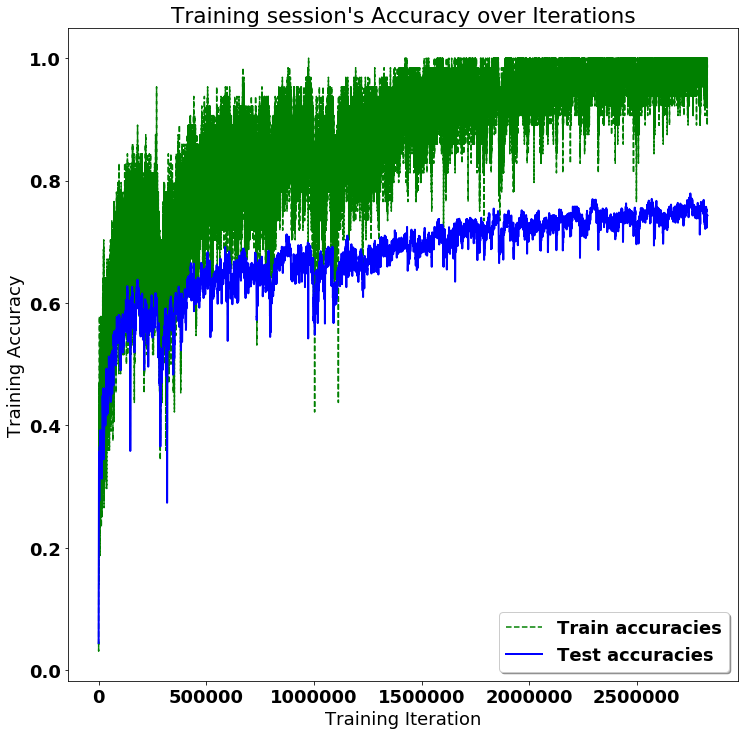

Testing Accuracy: 74.33198094367981%

Precision: 74.74765145798217%
Recall: 74.33198380566802%
f1_score: 74.15021595619048%

Confusion Matrix:
Created using test set of 2470 datapoints, normalised to % of each class in the test dataset


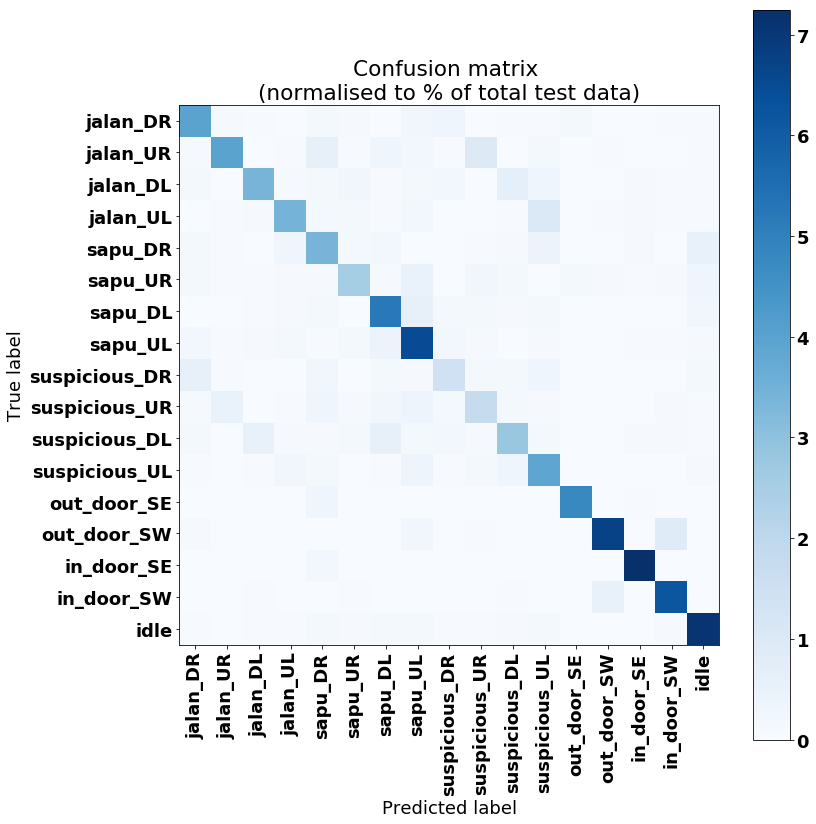

In [15]:
# (Inline plots: )
%matplotlib inline

font = {
    'family' : 'Bitstream Vera Sans',
    'weight' : 'bold',
    'size'   : 18
}
matplotlib.rc('font', **font)

width = 12
height = 12
plt.figure(figsize=(width, height))

indep_train_axis = np.array(range(batch_size, (len(train_losses)+1)*batch_size, batch_size))
#plt.plot(indep_train_axis, np.array(train_losses),     "b--", label="Train losses")
plt.plot(indep_train_axis, np.array(train_accuracies), "g--", label="Train accuracies")

indep_test_axis = np.append(
    np.array(range(batch_size, len(test_losses)*display_iter, display_iter)[:-1]),
    [training_iters]
)
#plt.plot(indep_test_axis, np.array(test_losses), "b-", linewidth=2.0, label="Test losses")
plt.plot(indep_test_axis, np.array(test_accuracies), "b-", linewidth=2.0, label="Test accuracies")
print(len(test_accuracies))
print(len(train_accuracies))

plt.title("Training session's Accuracy over Iterations")
plt.legend(loc='lower right', shadow=True)
plt.ylabel('Training Accuracy')
plt.xlabel('Training Iteration')

plt.show()

# Results

predictions = one_hot_predictions.argmax(1)

print("Testing Accuracy: {}%".format(100*accuracy_fin))

print("")
print("Precision: {}%".format(100*metrics.precision_score(y_test, predictions, average="weighted")))
print("Recall: {}%".format(100*metrics.recall_score(y_test, predictions, average="weighted")))
print("f1_score: {}%".format(100*metrics.f1_score(y_test, predictions, average="weighted")))

print("")
print("Confusion Matrix:")
print("Created using test set of {} datapoints, normalised to % of each class in the test dataset".format(len(y_test)))
confusion_matrix = metrics.confusion_matrix(y_test, predictions)


#print(confusion_matrix)
normalised_confusion_matrix = np.array(confusion_matrix, dtype=np.float32)/np.sum(confusion_matrix)*100


# Plot Results: 
width = 12
height = 12
plt.figure(figsize=(width, height))
plt.imshow(
    normalised_confusion_matrix, 
    interpolation='nearest', 
    cmap=plt.cm.Blues
)
plt.title("Confusion matrix \n(normalised to % of total test data)")
plt.colorbar()
tick_marks = np.arange(n_classes)
plt.xticks(tick_marks, LABELS, rotation=90)
plt.yticks(tick_marks, LABELS)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()


In [16]:


#
#X_val_path = DATASET_PATH + "X_val.txt"
#X_val = load_X(X_val_path)
#print X_val
#
#preds = sess.run(
#    [pred],
#    feed_dict={
#        x: X_val
#   }
#)
#
#print preds

In [17]:
#sess.close()
print(test_accuracies)

[0.04453441, 0.1708502, 0.25668016, 0.32510123, 0.35668015, 0.32712552, 0.2769231, 0.33279353, 0.33522266, 0.35789475, 0.36558706, 0.345749, 0.33522266, 0.32753035, 0.37813765, 0.3923077, 0.35587046, 0.33157894, 0.34331983, 0.31862348, 0.35748988, 0.36639675, 0.3611336, 0.34453443, 0.35829958, 0.37732795, 0.3813765, 0.35789475, 0.31295547, 0.34331983, 0.32064778, 0.3437247, 0.38218623, 0.3910931, 0.4105263, 0.4449393, 0.448583, 0.43927124, 0.4202429, 0.4202429, 0.43279353, 0.44008097, 0.4506073, 0.4388664, 0.46072873, 0.4506073, 0.45101213, 0.34493926, 0.35263157, 0.3716599, 0.37651822, 0.4048583, 0.40323886, 0.4331984, 0.44615385, 0.41862348, 0.41417003, 0.41214576, 0.4591093, 0.44777328, 0.41983807, 0.4, 0.40688258, 0.4376518, 0.45465586, 0.44008097, 0.43927124, 0.45789474, 0.48137653, 0.47975707, 0.45951417, 0.49271256, 0.43927124, 0.4449393, 0.43846154, 0.41700405, 0.4748988, 0.45789474, 0.4417004, 0.4493927, 0.44979757, 0.43846154, 0.42307693, 0.41983807, 0.4825911, 0.4680162, 0.4

## Conclusion

Final accuracy of >90% is pretty good, considering that training takes about 7 minutes.

Noticeable confusion between activities of Clapping Hands and Boxing, and between Jumping Jacks and Waving Two Hands which is understandable.

In terms of the applicability of this to a wider dataset, I would imagine that it would be able to work for any activities in which the training included a views from all angles to be tested on. It would be interesting to see it's applicability to camera angles in between the 4 used in this dataset, without training on them specifically.

 Overall, this experiment validates the idea that 2D pose can be used for at least human activity recognition, and provides verification to continue onto use of 2D pose for behaviour estimation in both people and animals
 

 ### With regards to Using LSTM-RNNs
 - Batch sampling
     - It is neccessary to ensure you are not just sampling classes one at a time! (ie y_train is ordered by class and batch chosen in order)The use of random sampling of batches without replacement from the training data resolves this.    
 
 - Architecture
     - Testing has been run using a variety of hidden units per LSTM cell, with results showing that testing accuracy achieves a higher score when using a number of hidden cells approximately equal to that of the input, ie 34. The following figure displays the final accuracy achieved on the testing dataset for a variety of hidden units, all using a batch size of 4096 and 300 epochs (a total of 1657 iterations, with testing performed every 8th iteration).
   
 
 

## Future Works

Inclusion of :

 - A pipeline for qualitative results
 - A validation dataset
 - Momentum     
 - Normalise input data (each point with respect to distribution of itself only)
 - Dropout
 - Comparison of effect of changing batch size
 

Further research will be made into the use on more subtle activity classes, such as walking versus running, agitated movement versus calm movement, and perhaps normal versus abnormal behaviour, based on a baseline of normal motion.


## References

The dataset can be found at http://tele-immersion.citris-uc.org/berkeley_mhad released under the BSD-2 license
>Copyright (c) 2013, Regents of the University of California All rights reserved.

The network used in this experiment is based on the following, available under the [MIT License](https://github.com/guillaume-chevalier/LSTM-Human-Activity-Recognition/blob/master/LICENSE). :
> Guillaume Chevalier, LSTMs for Human Activity Recognition, 2016
> https://github.com/guillaume-chevalier/LSTM-Human-Activity-Recognition



In [18]:
# Let's convert this notebook to a README for the GitHub project's title page:
!jupyter nbconvert --to markdown LSTM.ipynb
!mv LSTM.md README.md

[NbConvertApp] Converting notebook LSTM.ipynb to markdown
[NbConvertApp] Writing 1021182 bytes to LSTM.md


## 

In [19]:
#### Camera

# import argparse
# import logging
# import time

# import cv2
# import numpy as np

# from tf_pose.estimator import TfPoseEstimator
# from tf_pose.networks import get_graph_path, model_wh

# logger = logging.getLogger('TfPoseEstimator-WebCam')
# logger.setLevel(logging.DEBUG)
# ch = logging.StreamHandler()
# ch.setLevel(logging.DEBUG)
# formatter = logging.Formatter('[%(asctime)s] [%(name)s] [%(levelname)s] %(message)s')
# ch.setFormatter(formatter)
# logger.addHandler(ch)

# class openpose:
#     def __init__(self, camera=0,resize='0x0',resize_out_ratio=4.0,model='mobilenet_thin',show_process=False):

#         logger.debug('initialization %s : %s' % (model, get_graph_path(model)))
#         w, h = model_wh(resize)
#         if w > 0 and h > 0:
#             e = TfPoseEstimator(get_graph_path(model), target_size=(w, h))
#         else:
#             e = TfPoseEstimator(get_graph_path(model), target_size=(432, 368))
#         logger.debug('cam read+')
#         cam = cv2.VideoCapture(camera)
#         ret_val, image = cam.read()
#         logger.info('cam image=%dx%d' % (image.shape[1], image.shape[0]))
        
#         fps_time = 0

#         while True:
#             ret_val, image = cam.read()

#             logger.debug('image process+')
#             humans = e.inference(image, resize_to_default=(w > 0 and h > 0), upsample_size=resize_out_ratio)

#             logger.debug('postprocess+')
#             image = TfPoseEstimator.draw_humans(image, humans, imgcopy=False)

#             logger.debug('show+')
#             cv2.putText(image,
#                         "FPS: %f" % (1.0 / (time.time() - fps_time)),
#                         (10, 10),  cv2.FONT_HERSHEY_SIMPLEX, 0.5,
#                         (0, 255, 0), 2)
#             cv2.imshow('tf-pose-estimation result', image)
#             fps_time = time.time()
#             if cv2.waitKey(1) == 27:
#                 break
#             logger.debug('finished+')

#         cv2.destroyAllWindows()

# if __name__ == '__main__':
#     openpose()
